# Import packages.

In [57]:
import sys
from pathlib import Path

# Ensure repository root is on sys.path so `notebooks.utils` is importable
repo_root = Path.cwd().resolve()
for candidate in (repo_root, *repo_root.parents):
    if (candidate / "notebooks" / "utils" / "load_training_data.py").exists():
        repo_root = candidate
        break
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import math
import os
from typing import Optional, Iterable, Sequence, Mapping, Dict, Union, Callable, MutableMapping, MutableSequence

from notebooks.utils.create_heatmap_function import plot_min_test_loss_heatmap
from notebooks.utils.load_training_data import load_training_results
from notebooks.utils.merge_neural_behavioral import merge_behavioral_and_neural

         seed 1    seed 2    seed 3    seed 4    seed 5
epoch                                                  
0      0.484555  0.412808  0.438873  0.440987  0.447720
1      0.471111  0.420429  0.451321  0.444601  0.425774
2      0.475897  0.450065  0.470742  0.450438  0.440725
3      0.494714  0.464822  0.486271  0.452103  0.450335
4      0.515367  0.492248  0.508178  0.462139  0.478592
...         ...       ...       ...       ...       ...
120         NaN       NaN  0.812142       NaN  0.809446
121         NaN       NaN  0.811979       NaN  0.808039
122         NaN       NaN  0.811167       NaN  0.808016
123         NaN       NaN       NaN       NaN  0.807369
124         NaN       NaN       NaN       NaN  0.807031

[125 rows x 5 columns]


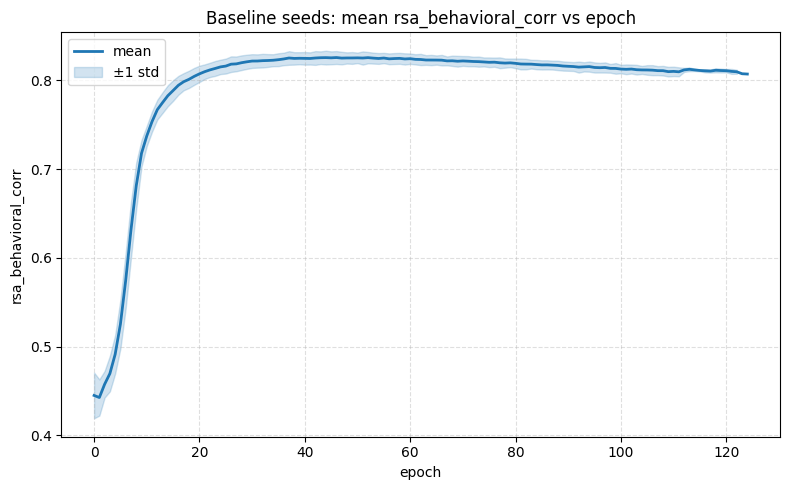

In [59]:
base = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/test')

# Collect rsa_behavioral_corr series for each seed and align on epoch
rsa_series = []
missing = []
for seed in range(1, 6):
    path = base / f'baseline_seed{seed}' / f'vit_l_14_rank32_perturb-type-none_init-seed{seed}behavioral-rsa-True' / 'training_res.csv'
    if not path.exists():
        missing.append(f'seed {seed} (file not found)')
        continue
    df = pd.read_csv(path)
    if 'rsa_behavioral_corr' not in df.columns:
        missing.append(f'seed {seed} (no rsa_behavioral_corr column)')
        continue
    rsa_series.append(df.set_index('epoch')['rsa_behavioral_corr'].rename(f'seed {seed}'))

if missing:
    print('Skipped runs:', '; '.join(missing))

if not rsa_series:
    raise SystemExit('No rsa_behavioral_corr data available to plot.')

rsa_df = pd.concat(rsa_series, axis=1).sort_index()

print(rsa_df)

mean_corr = rsa_df.mean(axis=1)
std_corr = rsa_df.std(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(mean_corr.index, mean_corr.values, label='mean', color='C0', lw=2)
plt.fill_between(
    mean_corr.index,
    (mean_corr - std_corr).values,
    (mean_corr + std_corr).values,
    color='C0',
    alpha=0.2,
    label='±1 std',
)
plt.xlabel('epoch')
plt.ylabel('rsa_behavioral_corr')
plt.title('Baseline seeds: mean rsa_behavioral_corr vs epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

In [60]:
base = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/test')

# Collect all training_res.csv files for random_target perturbations, keyed by (seed, epoch)
sweep_ba_results = {}
missing = []

for seed_dir in sorted(base.glob('random_target_perturb_seed*')):
    m_seed = re.search(r'seed(\d+)$', seed_dir.name)
    if not m_seed:
        continue
    seed = int(m_seed.group(1))

    for epoch_dir in sorted(seed_dir.glob('epoch*_length1')):
        m_epoch = re.search(r'epoch(\d+)_length', epoch_dir.name)
        if not m_epoch:
            continue
        epoch = int(m_epoch.group(1))

        csv_candidates = sorted(epoch_dir.rglob('training_res.csv'))
        if not csv_candidates:
            missing.append(f'seed {seed}, epoch {epoch}')
            continue
        csv_path = csv_candidates[0]
        sweep_ba_results[(seed, epoch)] = pd.read_csv(csv_path)

if missing:
    print('Missing training_res.csv for:', '; '.join(missing))
print(f'Loaded {len(sweep_ba_results)} training_res.csv files into sweep_ba_results')

Missing training_res.csv for: seed 2, epoch 1
Loaded 80 training_res.csv files into sweep_ba_results


In [81]:
# DEBUG CELL
for seed in range(1, 4):
    # print(f'seed {seed}')
    for epoch in range(1, 10):
        # print(f'epoch {epoch}')
        value = rsa_df.loc[epoch, f'seed {seed}']
        # print(value)

In [ ]:
# Compute sweep minus baseline rsa_behavioral_corr per (seed, epoch)

sweep_ba_diff = {}
for seed in sorted({key[0] for key in sweep_ba_results.keys()}):
    # Extract all (seed, epoch) for this seed, and sort by epoch
    epoch_keys = sorted(
        [(s, epoch) for (s, epoch) in sweep_ba_results.keys() if s == seed],
        key=lambda x: x[1]
    )
    for (s, epoch_key) in epoch_keys:
        sweep_df = sweep_ba_results[(s, epoch_key)]
        print(f'seed: {seed}, epoch_key: {epoch_key}')
        sweep_series = sweep_df.set_index('epoch')['rsa_behavioral_corr']
        #print(sweep_series)
        sweep_value = sweep_series[sweep_series.index == epoch_key].iloc[0]
        print(f'sweep_value: {sweep_value}')
        baseline_value = rsa_df.loc[epoch_key, f'seed {seed}']
        print(f'baseline_value: {baseline_value}')
        diff = sweep_value - baseline_value
        print(f'diff: {diff}')
        print("="*40)
        # Optionally, populate the results dict
        sweep_ba_diff[(seed, epoch_key)] = diff

print(f'Computed diffs for {len(sweep_ba_diff)} runs; keys like (seed, epoch):', list(sweep_ba_diff.keys())[:5])

print(sweep_ba_diff)

seed: 1, epoch_key: 0
sweep_value: 0.4760440570337063
baseline_value: 0.4845554593948589
diff: -0.008511402361152609
seed: 1, epoch_key: 1
sweep_value: 0.4787930371437687
baseline_value: 0.4711106585243997
diff: 0.00768237861936899
seed: 1, epoch_key: 2
sweep_value: 0.5223337136916169
baseline_value: 0.4758966878636244
diff: 0.04643702582799247
seed: 1, epoch_key: 3
sweep_value: 0.547816724586885
baseline_value: 0.4947136740887209
diff: 0.053103050498164106
seed: 1, epoch_key: 4
sweep_value: 0.5660254991593469
baseline_value: 0.5153669665511528
diff: 0.050658532608194085
seed: 1, epoch_key: 5
sweep_value: 0.5939691385481128
baseline_value: 0.5486879107310629
diff: 0.04528122781704991
seed: 1, epoch_key: 6
sweep_value: 0.633586627289325
baseline_value: 0.59324448372041
diff: 0.04034214356891497
seed: 1, epoch_key: 7
sweep_value: 0.6708607746296377
baseline_value: 0.6471243513228591
diff: 0.02373642330677861
seed: 1, epoch_key: 8
sweep_value: 0.7003457050736545
baseline_value: 0.69480165

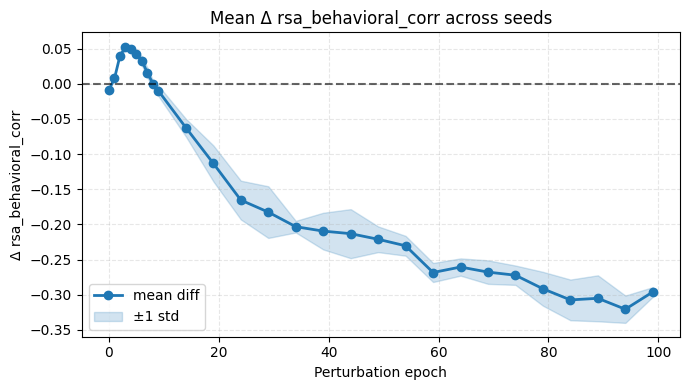

In [80]:
records = []
for (seed, epoch_key), diff_val in sweep_ba_diff.items():
    val = float(diff_val)
    records.append({'seed': seed, 'epoch': epoch_key, 'diff': val})

diff_df = pd.DataFrame(records)
mean_df = diff_df.groupby('epoch')['diff'].agg(['mean','std']).reset_index()

plt.figure(figsize=(7,4))
plt.plot(mean_df['epoch'], mean_df['mean'], marker='o', lw=2, color='C0', label='mean diff')
plt.fill_between(mean_df['epoch'], mean_df['mean']-mean_df['std'], mean_df['mean']+mean_df['std'], color='C0', alpha=0.2, label='±1 std')
plt.axhline(0, color='black', linestyle='--', alpha=0.6)
plt.title('Mean Δ rsa_behavioral_corr across seeds')
plt.xlabel('Perturbation epoch')
plt.ylabel('Δ rsa_behavioral_corr')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

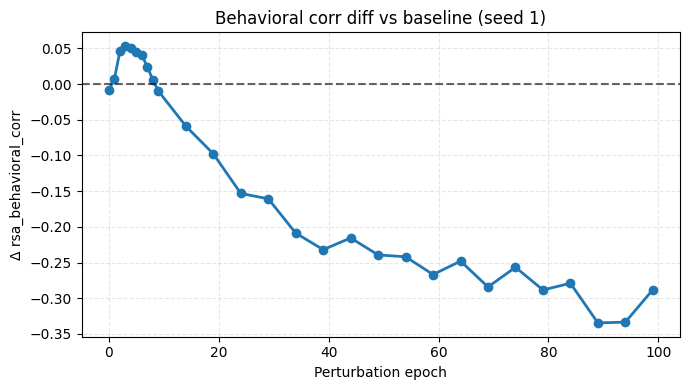

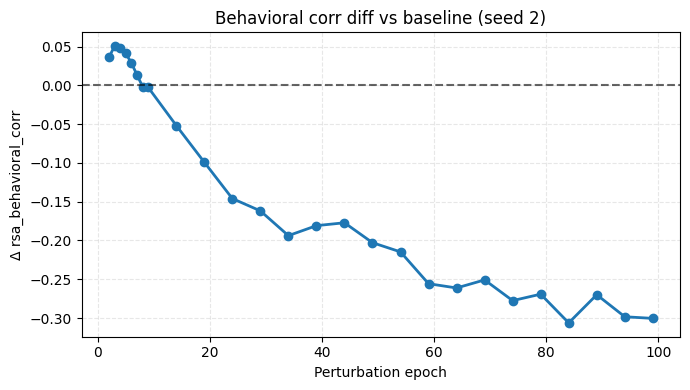

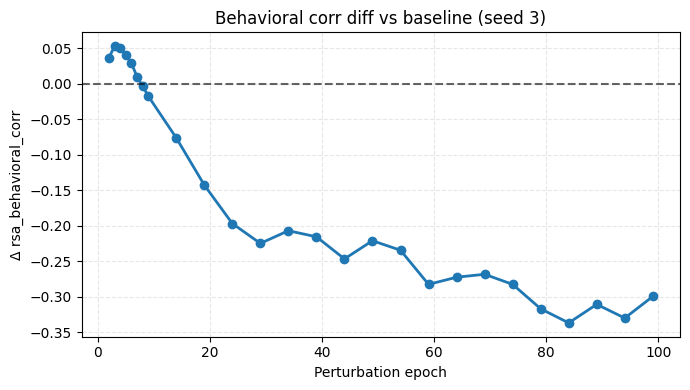

In [78]:
# Convert to DataFrame with rows=epoch, columns=seed, values=diff (mean over series if needed)
records = []
for (seed, epoch_key), diff_val in sweep_ba_diff.items():
    val = float(diff_val)
    records.append({'seed': seed, 'epoch': epoch_key, 'diff': val})

diff_df = pd.DataFrame(records)

# Plot one figure per seed
for seed, g in diff_df.groupby('seed'):
    g = g.sort_values('epoch')
    plt.figure(figsize=(7,4))
    plt.plot(g['epoch'], g['diff'], marker='o', lw=2)
    plt.axhline(0, color='black', linestyle='--', alpha=0.6)
    plt.title(f'Behavioral corr diff vs baseline (seed {seed})')
    plt.xlabel('Perturbation epoch')
    plt.ylabel('Δ rsa_behavioral_corr')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [82]:
base = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/test')

# Collect all training_res.csv files for random_target perturbations, keyed by (seed, epoch)
sweep_ba_results = {}
missing = []

for seed_dir in sorted(base.glob('image_noise_perturb_seed*')):
    m_seed = re.search(r'seed(\d+)$', seed_dir.name)
    if not m_seed:
        continue
    seed = int(m_seed.group(1))

    for epoch_dir in sorted(seed_dir.glob('epoch*_length1')):
        m_epoch = re.search(r'epoch(\d+)_length', epoch_dir.name)
        if not m_epoch:
            continue
        epoch = int(m_epoch.group(1))

        csv_candidates = sorted(epoch_dir.rglob('training_res.csv'))
        if not csv_candidates:
            missing.append(f'seed {seed}, epoch {epoch}')
            continue
        csv_path = csv_candidates[0]
        sweep_ba_results[(seed, epoch)] = pd.read_csv(csv_path)

if missing:
    print('Missing training_res.csv for:', '; '.join(missing))
print(f'Loaded {len(sweep_ba_results)} training_res.csv files into sweep_ba_results')

Missing training_res.csv for: seed 2, epoch 1
Loaded 80 training_res.csv files into sweep_ba_results


In [83]:
# Compute sweep minus baseline rsa_behavioral_corr per (seed, epoch)

sweep_ba_diff = {}
for seed in sorted({key[0] for key in sweep_ba_results.keys()}):
    # Extract all (seed, epoch) for this seed, and sort by epoch
    epoch_keys = sorted(
        [(s, epoch) for (s, epoch) in sweep_ba_results.keys() if s == seed],
        key=lambda x: x[1]
    )
    for (s, epoch_key) in epoch_keys:
        sweep_df = sweep_ba_results[(s, epoch_key)]
        print(f'seed: {seed}, epoch_key: {epoch_key}')
        sweep_series = sweep_df.set_index('epoch')['rsa_behavioral_corr']
        #print(sweep_series)
        sweep_value = sweep_series[sweep_series.index == epoch_key].iloc[0]
        print(f'sweep_value: {sweep_value}')
        baseline_value = rsa_df.loc[epoch_key, f'seed {seed}']
        print(f'baseline_value: {baseline_value}')
        diff = sweep_value - baseline_value
        print(f'diff: {diff}')
        print("="*40)
        # Optionally, populate the results dict
        sweep_ba_diff[(seed, epoch_key)] = diff

print(f'Computed diffs for {len(sweep_ba_diff)} runs; keys like (seed, epoch):', list(sweep_ba_diff.keys())[:5])

print(sweep_ba_diff)

seed: 1, epoch_key: 0
sweep_value: 0.4674636827919731
baseline_value: 0.4845554593948589
diff: -0.0170917766028858
seed: 1, epoch_key: 1
sweep_value: 0.4780283563458339
baseline_value: 0.4711106585243997
diff: 0.006917697821434199
seed: 1, epoch_key: 2
sweep_value: 0.4942286327990677
baseline_value: 0.4758966878636244
diff: 0.018331944935443323
seed: 1, epoch_key: 3
sweep_value: 0.5015092008498605
baseline_value: 0.4947136740887209
diff: 0.006795526761139592
seed: 1, epoch_key: 4
sweep_value: 0.5201792158662328
baseline_value: 0.5153669665511528
diff: 0.004812249315080064
seed: 1, epoch_key: 5
sweep_value: 0.5293209642266827
baseline_value: 0.5486879107310629
diff: -0.0193669465043802
seed: 1, epoch_key: 6
sweep_value: 0.5528148987500519
baseline_value: 0.59324448372041
diff: -0.0404295849703582
seed: 1, epoch_key: 7
sweep_value: 0.5914348465361703
baseline_value: 0.6471243513228591
diff: -0.05568950478668877
seed: 1, epoch_key: 8
sweep_value: 0.6332289178498395
baseline_value: 0.69480

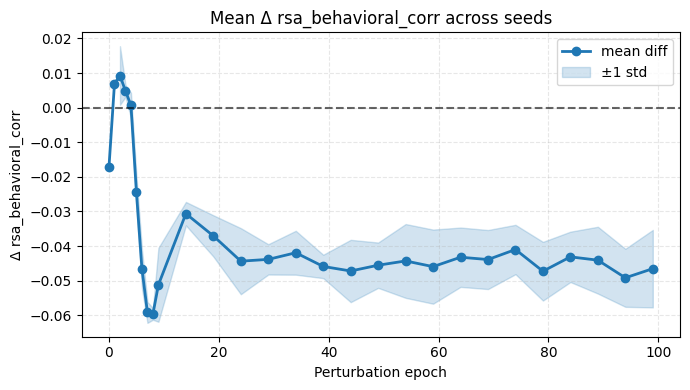

In [84]:
records = []
for (seed, epoch_key), diff_val in sweep_ba_diff.items():
    val = float(diff_val)
    records.append({'seed': seed, 'epoch': epoch_key, 'diff': val})

diff_df = pd.DataFrame(records)
mean_df = diff_df.groupby('epoch')['diff'].agg(['mean','std']).reset_index()

plt.figure(figsize=(7,4))
plt.plot(mean_df['epoch'], mean_df['mean'], marker='o', lw=2, color='C0', label='mean diff')
plt.fill_between(mean_df['epoch'], mean_df['mean']-mean_df['std'], mean_df['mean']+mean_df['std'], color='C0', alpha=0.2, label='±1 std')
plt.axhline(0, color='black', linestyle='--', alpha=0.6)
plt.title('Mean Δ rsa_behavioral_corr across seeds')
plt.xlabel('Perturbation epoch')
plt.ylabel('Δ rsa_behavioral_corr')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [85]:
base = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/test')

# Collect all training_res.csv files for random_target perturbations, keyed by (seed, epoch)
sweep_ba_results = {}
missing = []

for seed_dir in sorted(base.glob('label_shuffle_perturb_seed*')):
    m_seed = re.search(r'seed(\d+)$', seed_dir.name)
    if not m_seed:
        continue
    seed = int(m_seed.group(1))

    for epoch_dir in sorted(seed_dir.glob('epoch*_length1')):
        m_epoch = re.search(r'epoch(\d+)_length', epoch_dir.name)
        if not m_epoch:
            continue
        epoch = int(m_epoch.group(1))

        csv_candidates = sorted(epoch_dir.rglob('training_res.csv'))
        if not csv_candidates:
            missing.append(f'seed {seed}, epoch {epoch}')
            continue
        csv_path = csv_candidates[0]
        sweep_ba_results[(seed, epoch)] = pd.read_csv(csv_path)

if missing:
    print('Missing training_res.csv for:', '; '.join(missing))
print(f'Loaded {len(sweep_ba_results)} training_res.csv files into sweep_ba_results')

Loaded 50 training_res.csv files into sweep_ba_results


In [86]:
# Compute sweep minus baseline rsa_behavioral_corr per (seed, epoch)

sweep_ba_diff = {}
for seed in sorted({key[0] for key in sweep_ba_results.keys()}):
    # Extract all (seed, epoch) for this seed, and sort by epoch
    epoch_keys = sorted(
        [(s, epoch) for (s, epoch) in sweep_ba_results.keys() if s == seed],
        key=lambda x: x[1]
    )
    for (s, epoch_key) in epoch_keys:
        sweep_df = sweep_ba_results[(s, epoch_key)]
        print(f'seed: {seed}, epoch_key: {epoch_key}')
        sweep_series = sweep_df.set_index('epoch')['rsa_behavioral_corr']
        #print(sweep_series)
        sweep_value = sweep_series[sweep_series.index == epoch_key].iloc[0]
        print(f'sweep_value: {sweep_value}')
        baseline_value = rsa_df.loc[epoch_key, f'seed {seed}']
        print(f'baseline_value: {baseline_value}')
        diff = sweep_value - baseline_value
        print(f'diff: {diff}')
        print("="*40)
        # Optionally, populate the results dict
        sweep_ba_diff[(seed, epoch_key)] = diff

print(f'Computed diffs for {len(sweep_ba_diff)} runs; keys like (seed, epoch):', list(sweep_ba_diff.keys())[:5])

print(sweep_ba_diff)

seed: 1, epoch_key: 2
sweep_value: 0.4731929629615271
baseline_value: 0.4758966878636244
diff: -0.002703724902097304
seed: 1, epoch_key: 3
sweep_value: 0.4832820978283629
baseline_value: 0.4947136740887209
diff: -0.011431576260358012
seed: 1, epoch_key: 4
sweep_value: 0.495955880049057
baseline_value: 0.5153669665511528
diff: -0.019411086502095776
seed: 1, epoch_key: 5
sweep_value: 0.5182909997711271
baseline_value: 0.5486879107310629
diff: -0.030396910959935797
seed: 1, epoch_key: 6
sweep_value: 0.5483484218291389
baseline_value: 0.59324448372041
diff: -0.044896061891271155
seed: 1, epoch_key: 7
sweep_value: 0.5887160077473617
baseline_value: 0.6471243513228591
diff: -0.0584083435754974
seed: 1, epoch_key: 8
sweep_value: 0.6275676245405808
baseline_value: 0.6948016591854868
diff: -0.06723403464490596
seed: 1, epoch_key: 9
sweep_value: 0.6640945607082964
baseline_value: 0.7328403692271608
diff: -0.06874580851886436
seed: 1, epoch_key: 14
sweep_value: 0.6979215195415908
baseline_value: 

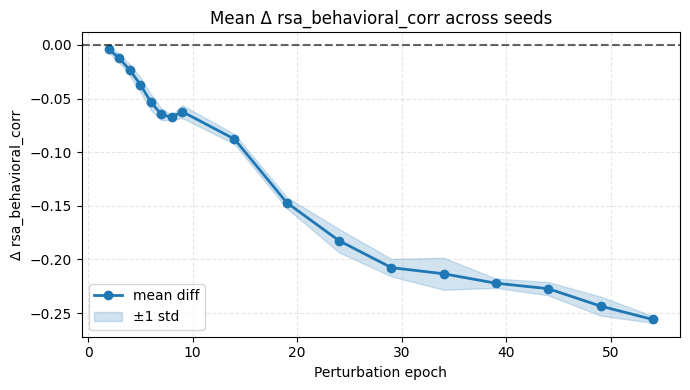

In [87]:
records = []
for (seed, epoch_key), diff_val in sweep_ba_diff.items():
    val = float(diff_val)
    records.append({'seed': seed, 'epoch': epoch_key, 'diff': val})

diff_df = pd.DataFrame(records)
mean_df = diff_df.groupby('epoch')['diff'].agg(['mean','std']).reset_index()

plt.figure(figsize=(7,4))
plt.plot(mean_df['epoch'], mean_df['mean'], marker='o', lw=2, color='C0', label='mean diff')
plt.fill_between(mean_df['epoch'], mean_df['mean']-mean_df['std'], mean_df['mean']+mean_df['std'], color='C0', alpha=0.2, label='±1 std')
plt.axhline(0, color='black', linestyle='--', alpha=0.6)
plt.title('Mean Δ rsa_behavioral_corr across seeds')
plt.xlabel('Perturbation epoch')
plt.ylabel('Δ rsa_behavioral_corr')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [88]:
base = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/test')

# Collect all training_res.csv files for random_target perturbations, keyed by (seed, epoch)
sweep_ba_results = {}
missing = []

for seed_dir in sorted(base.glob('uniform_images_perturb_seed*')):
    m_seed = re.search(r'seed(\d+)$', seed_dir.name)
    if not m_seed:
        continue
    seed = int(m_seed.group(1))

    for epoch_dir in sorted(seed_dir.glob('epoch*_length1')):
        m_epoch = re.search(r'epoch(\d+)_length', epoch_dir.name)
        if not m_epoch:
            continue
        epoch = int(m_epoch.group(1))

        csv_candidates = sorted(epoch_dir.rglob('training_res.csv'))
        if not csv_candidates:
            missing.append(f'seed {seed}, epoch {epoch}')
            continue
        csv_path = csv_candidates[0]
        sweep_ba_results[(seed, epoch)] = pd.read_csv(csv_path)

if missing:
    print('Missing training_res.csv for:', '; '.join(missing))
print(f'Loaded {len(sweep_ba_results)} training_res.csv files into sweep_ba_results')

Loaded 39 training_res.csv files into sweep_ba_results


In [89]:
# Compute sweep minus baseline rsa_behavioral_corr per (seed, epoch)

sweep_ba_diff = {}
for seed in sorted({key[0] for key in sweep_ba_results.keys()}):
    # Extract all (seed, epoch) for this seed, and sort by epoch
    epoch_keys = sorted(
        [(s, epoch) for (s, epoch) in sweep_ba_results.keys() if s == seed],
        key=lambda x: x[1]
    )
    for (s, epoch_key) in epoch_keys:
        sweep_df = sweep_ba_results[(s, epoch_key)]
        print(f'seed: {seed}, epoch_key: {epoch_key}')
        sweep_series = sweep_df.set_index('epoch')['rsa_behavioral_corr']
        #print(sweep_series)
        sweep_value = sweep_series[sweep_series.index == epoch_key].iloc[0]
        print(f'sweep_value: {sweep_value}')
        baseline_value = rsa_df.loc[epoch_key, f'seed {seed}']
        print(f'baseline_value: {baseline_value}')
        diff = sweep_value - baseline_value
        print(f'diff: {diff}')
        print("="*40)
        # Optionally, populate the results dict
        sweep_ba_diff[(seed, epoch_key)] = diff

print(f'Computed diffs for {len(sweep_ba_diff)} runs; keys like (seed, epoch):', list(sweep_ba_diff.keys())[:5])

print(sweep_ba_diff)

seed: 1, epoch_key: 0
sweep_value: 0.4700343591418617
baseline_value: 0.4845554593948589
diff: -0.014521100252997188
seed: 1, epoch_key: 1
sweep_value: 0.4526459895638579
baseline_value: 0.4711106585243997
diff: -0.01846466896054183
seed: 1, epoch_key: 2
sweep_value: 0.4445316105359174
baseline_value: 0.4758966878636244
diff: -0.03136507732770699
seed: 1, epoch_key: 3
sweep_value: 0.4517479120681845
baseline_value: 0.4947136740887209
diff: -0.042965762020536424
seed: 1, epoch_key: 4
sweep_value: 0.4821622641171741
baseline_value: 0.5153669665511528
diff: -0.03320470243397866
seed: 1, epoch_key: 5
sweep_value: 0.5049179027889563
baseline_value: 0.5486879107310629
diff: -0.043770007942106615
seed: 1, epoch_key: 6
sweep_value: 0.533597396462065
baseline_value: 0.59324448372041
diff: -0.059647087258345
seed: 1, epoch_key: 7
sweep_value: 0.5793466512432776
baseline_value: 0.6471243513228591
diff: -0.0677777000795815
seed: 1, epoch_key: 8
sweep_value: 0.6272760329594667
baseline_value: 0.694

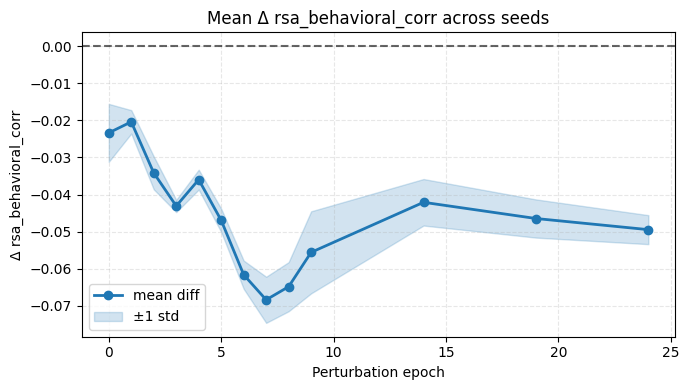

In [90]:
records = []
for (seed, epoch_key), diff_val in sweep_ba_diff.items():
    val = float(diff_val)
    records.append({'seed': seed, 'epoch': epoch_key, 'diff': val})

diff_df = pd.DataFrame(records)
mean_df = diff_df.groupby('epoch')['diff'].agg(['mean','std']).reset_index()

plt.figure(figsize=(7,4))
plt.plot(mean_df['epoch'], mean_df['mean'], marker='o', lw=2, color='C0', label='mean diff')
plt.fill_between(mean_df['epoch'], mean_df['mean']-mean_df['std'], mean_df['mean']+mean_df['std'], color='C0', alpha=0.2, label='±1 std')
plt.axhline(0, color='black', linestyle='--', alpha=0.6)
plt.title('Mean Δ rsa_behavioral_corr across seeds')
plt.xlabel('Perturbation epoch')
plt.ylabel('Δ rsa_behavioral_corr')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Load training data.

### Baseline behavioral alignment results


In [10]:
# Baseline Seed 1 Behavioral Alignment Results
baseline_seed1_ba_results = load_training_results(
    Path("../../data/training_results/baseline/training_res_seed1.csv"),
    truncate_at_min_test_loss=True,
)

# Baseline Seed 2 Behavioral Alignment Results
baseline_seed2_ba_results = load_training_results(
    Path("../../data/training_results/baseline/training_res_seed2.csv"),
    truncate_at_min_test_loss=True,
)

# Baseline Seed 3 Behavioral Alignment Results
baseline_seed3_ba_results = load_training_results(
    Path("../../data/training_results/baseline/training_res_seed3.csv"),
    truncate_at_min_test_loss=True,
)

### Baseline THINGS neural alignment results

In [10]:
# Baseline Seed 1 THINGS Neural Alignment Results
baseline_seed1_things_na_results = pd.read_csv('../../data/brain_rsa_results/baseline/things/things_baseline_seed1_brain_rsa_results.csv')

# Baseline Seed 2 THINGS Neural Alignment Results
baseline_seed2_things_na_results = pd.read_csv('../../data/brain_rsa_results/baseline/things/things_baseline_seed2_brain_rsa_results.csv')

# Baseline Seed 3 THINGS Neural Alignment Results
baseline_seed3_things_na_results = pd.read_csv('../../data/brain_rsa_results/baseline/things/things_baseline_seed3_brain_rsa_results.csv')

### Merge the baseline behavioral alignment results with the baseline THINGS neural alignment results.

In [11]:
## Merge the baseline behavioral alignment results with the baseline THINGS neural alignment results.

# Baseline Seed 1
baseline_seed1_things_df = merge_behavioral_and_neural(baseline_seed1_ba_results, baseline_seed1_things_na_results)

# Baseline Seed 2
baseline_seed2_things_df = merge_behavioral_and_neural(baseline_seed2_ba_results, baseline_seed2_things_na_results)

# Baseline Seed 3
baseline_seed3_things_df = merge_behavioral_and_neural(baseline_seed3_ba_results, baseline_seed3_things_na_results)

### Baseline NOD neural alignment results

In [12]:
# Baseline Seed 1 NOD Neural Alignment Results
baseline_seed1_nod_na_results = pd.read_csv('../../data/brain_rsa_results/baseline/nod/nod_baseline_seed1_brain_rsa_results.csv')

# Baseline Seed 2 NOD Neural Alignment Results
baseline_seed2_nod_na_results = pd.read_csv('../../data/brain_rsa_results/baseline/nod/nod_baseline_seed2_brain_rsa_results.csv')

# Baseline Seed 3 NOD Neural Alignment Results
baseline_seed3_nod_na_results = pd.read_csv('../../data/brain_rsa_results/baseline/nod/nod_baseline_seed3_brain_rsa_results.csv')

### Merge the baseline behavioral alignment results with the baseline NOD neural alignment results.

In [13]:
## Merge the baseline behavioral alignment results with the baseline NOD neural alignment results.

# Baseline Seed 1
baseline_seed1_nod_df = merge_behavioral_and_neural(baseline_seed1_ba_results, baseline_seed1_nod_na_results)

# Baseline Seed 2
baseline_seed2_nod_df = merge_behavioral_and_neural(baseline_seed2_ba_results, baseline_seed2_nod_na_results)

# Baseline Seed 3
baseline_seed3_nod_df = merge_behavioral_and_neural(baseline_seed3_ba_results, baseline_seed3_nod_na_results)

### Single-epoch perturbation behavioral alignment results

In [ ]:
# Single-epoch perturbation seed 1
sweep_seed1_ba_results = load_training_results(
    Path("/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42"),
    multiple_files=True,
)

# Single-epoch perturbation seed 2
sweep_seed2_ba_results = load_training_results(
    Path("/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed2_perturbseed43"),
    multiple_files=True,
)

# Single-epoch perturbation seed 3
sweep_seed3_ba_results = load_training_results(
    Path("/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed3_perturbseed44"),
    multiple_files=True,
)

### Single-epoch perturbation THINGS neural alignment results

In [15]:
# Single-epoch perturbation seed 1
sweep_seed1_things_neural_results = pd.read_csv('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42/compiled_inference_results_things_neural.csv')

# Single-epoch perturbation seed 2
sweep_seed2_things_neural_results = pd.read_csv('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed2_perturbseed43/compiled_inference_results_things_neural.csv')

# Single-epoch perturbation seed 3
sweep_seed3_things_neural_results = pd.read_csv('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed3_perturbseed44/compiled_inference_results_things_neural.csv')

### Single-epoch perturbation NOD neural alignment results

In [16]:
# Single-epoch perturbation seed 1
sweep_seed1_nod_neural_results = pd.read_csv('../../data/brain_rsa_results/single_epoch_sweep/nod/nod_sweep_seed42_brain_rsa_results.csv')

# Single-epoch perturbation seed 2
sweep_seed2_nod_neural_results = pd.read_csv('../../data/brain_rsa_results/single_epoch_sweep/nod/nod_sweep_seed43_brain_rsa_results.csv')

# Single-epoch perturbation seed 3
sweep_seed3_nod_neural_results = pd.read_csv('../../data/brain_rsa_results/single_epoch_sweep/nod/nod_sweep_seed44_brain_rsa_results.csv')

### Perturbation length experiments behavioral alignment results

In [17]:
# Path to base directory of the perturbation length experiments
seed1_perturb_length_base_dir = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/length_experiments/perturb_length_experiments_baselineseed1_perturbseed0')

# list all training run directories in the results_dir
seed1_perturb_length_run_dirs = sorted([d for d in seed1_perturb_length_base_dir.iterdir() 
                  if d.is_dir()
                  and d.name.startswith('random_target')])
# In every run_dir, find the folder called either metrics.csv or training_res.csv and read it in as a pandas dataframe

# All_perturb_length_dfs should be a dict mapping run names (strings) to DataFrames, or a list of DataFrames, where each DataFrame has a 'test_loss' column and its indices represent epochs. 

seed1_all_perturb_length_dfs = {}

for run_dir in seed1_perturb_length_run_dirs:
    if 'metrics.csv' in os.listdir(run_dir):
        # print(f'Found results csv in {run_dir.name}')
        df = pd.read_csv(run_dir / 'metrics.csv')
        seed1_all_perturb_length_dfs[run_dir.name] = df
    elif 'training_res.csv' in os.listdir(run_dir):
        # print(f'Found results csv in {run_dir.name}')
        df = pd.read_csv(run_dir / 'training_res.csv')
        seed1_all_perturb_length_dfs[run_dir.name] = df
# Filter out the rows that were from before early stopping kicked in (but after the minimum test loss was achieved)

seed1_all_perturb_length_data = {}

for run_name, df in seed1_all_perturb_length_dfs.items():
    if len(df) == 0:
        seed1_all_perturb_length_data[run_name] = df
        continue

    # Find the epoch with minimum test loss
    min_test_loss_idx = df['test_loss'].idxmin()

    # Keep all rows up to and including the minimum test loss epoch
    filtered_df = df.loc[:min_test_loss_idx].copy()

    seed1_all_perturb_length_data[run_name] = filtered_df

    # Print info about the filtering
    original_epochs = len(df)
    filtered_epochs = len(filtered_df)
    removed_epochs = original_epochs - filtered_epochs
    # print(f"{run_name}: {original_epochs} -> {filtered_epochs} epochs "
    #         f"(removed {removed_epochs} epochs after minimum test loss)")
# Extract metadata for each run
seed1_run_metadata = []
for run_name, df in seed1_all_perturb_length_dfs.items():
    # Parse run name - format appears to be "random_target_e{epoch}_l{length}"
    # Let's handle this more carefully
    if 'random_target_e' in run_name:
        # Extract epoch and length from format like "random_target_e70_l20"
        parts = run_name.split('_')
        start_epoch = None
        length = None
        
        for part in parts:
            if part.startswith('e') and part[1:].isdigit():
                start_epoch = int(part[1:])
            elif part.startswith('l') and part[1:].isdigit():
                length = int(part[1:])
        
        if start_epoch is not None and length is not None:
            seed1_run_metadata.append({
                'run_name': run_name,
                'start_epoch': start_epoch,
                'length': length,
                'df': df
            })
            
            # print(f"Run: {run_name}")
            # print(f"  Start epoch: {start_epoch}")
            # print(f"  Length: {length} epochs")
            # print(f"  Total epochs: {len(df)}")
            # print()
        else:
            print(f"Warning: Could not parse run name: {run_name}")
    else:
        print(f"Warning: Unexpected run name format: {run_name}")

# print(f"Total runs parsed: {len(seed1_run_metadata)}")

In [18]:
# Path to base directory of the perturbation length experiments
seed2_perturb_length_base_dir = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/length_experiments/perturb_length_experiments_baselineseed2_perturbseed1')

# list all training run directories in the results_dir
seed2_perturb_length_run_dirs = sorted([d for d in seed2_perturb_length_base_dir.iterdir() 
                  if d.is_dir()
                  and d.name.startswith('random_target')])
# In every run_dir, find the folder called either metrics.csv or training_res.csv and read it in as a pandas dataframe

# All_perturb_length_dfs should be a dict mapping run names (strings) to DataFrames, or a list of DataFrames, where each DataFrame has a 'test_loss' column and its indices represent epochs. 

seed2_all_perturb_length_dfs = {}

for run_dir in seed2_perturb_length_run_dirs:
    if 'metrics.csv' in os.listdir(run_dir):
        # print(f'Found results csv in {run_dir.name}')
        df = pd.read_csv(run_dir / 'metrics.csv')
        seed2_all_perturb_length_dfs[run_dir.name] = df
    elif 'training_res.csv' in os.listdir(run_dir):
        # print(f'Found results csv in {run_dir.name}')
        df = pd.read_csv(run_dir / 'training_res.csv')
        seed2_all_perturb_length_dfs[run_dir.name] = df
# Filter out the rows that were from before early stopping kicked in (but after the minimum test loss was achieved)

seed2_all_perturb_length_data = {}

for run_name, df in seed2_all_perturb_length_dfs.items():
    if len(df) == 0:
        seed2_all_perturb_length_data[run_name] = df
        continue

    # Find the epoch with minimum test loss
    min_test_loss_idx = df['test_loss'].idxmin()

    # Keep all rows up to and including the minimum test loss epoch
    filtered_df = df.loc[:min_test_loss_idx].copy()

    seed2_all_perturb_length_data[run_name] = filtered_df

    # Print info about the filtering
    original_epochs = len(df)
    filtered_epochs = len(filtered_df)
    removed_epochs = original_epochs - filtered_epochs
    # print(f"{run_name}: {original_epochs} -> {filtered_epochs} epochs "
    #         f"(removed {removed_epochs} epochs after minimum test loss)")
# Extract metadata for each run
seed2_run_metadata = []
for run_name, df in seed2_all_perturb_length_dfs.items():
    # Parse run name - format appears to be "random_target_e{epoch}_l{length}"
    # Let's handle this more carefully
    if 'random_target_e' in run_name:
        # Extract epoch and length from format like "random_target_e70_l20"
        parts = run_name.split('_')
        start_epoch = None
        length = None
        
        for part in parts:
            if part.startswith('e') and part[1:].isdigit():
                start_epoch = int(part[1:])
            elif part.startswith('l') and part[1:].isdigit():
                length = int(part[1:])
        
        if start_epoch is not None and length is not None:
            seed2_run_metadata.append({
                'run_name': run_name,
                'start_epoch': start_epoch,
                'length': length,
                'df': df
            })
            
            # print(f"Run: {run_name}")
            # print(f"  Start epoch: {start_epoch}")
            # print(f"  Length: {length} epochs")
            # print(f"  Total epochs: {len(df)}")
            # print()
        else:
            print(f"Warning: Could not parse run name: {run_name}")
    else:
        print(f"Warning: Unexpected run name format: {run_name}")

# print(f"Total runs parsed: {len(seed2_run_metadata)}")

In [19]:
# Path to base directory of the perturbation length experiments
seed3_perturb_length_base_dir = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/length_experiments/perturb_length_experiments_baselineseed3_perturbseed2')

# list all training run directories in the results_dir
seed3_perturb_length_run_dirs = sorted([d for d in seed3_perturb_length_base_dir.iterdir() 
                  if d.is_dir()
                  and d.name.startswith('random_target')])
# In every run_dir, find the folder called either metrics.csv or training_res.csv and read it in as a pandas dataframe

# All_perturb_length_dfs should be a dict mapping run names (strings) to DataFrames, or a list of DataFrames, where each DataFrame has a 'test_loss' column and its indices represent epochs. 

seed3_all_perturb_length_dfs = {}

for run_dir in seed3_perturb_length_run_dirs:
    if 'metrics.csv' in os.listdir(run_dir):
        # print(f'Found results csv in {run_dir.name}')
        df = pd.read_csv(run_dir / 'metrics.csv')
        seed3_all_perturb_length_dfs[run_dir.name] = df
    elif 'training_res.csv' in os.listdir(run_dir):
        # print(f'Found results csv in {run_dir.name}')
        df = pd.read_csv(run_dir / 'training_res.csv')
        seed3_all_perturb_length_dfs[run_dir.name] = df
# Filter out the rows that were from before early stopping kicked in (but after the minimum test loss was achieved)

seed3_all_perturb_length_data = {}

for run_name, df in seed3_all_perturb_length_dfs.items():
    if len(df) == 0:
        seed3_all_perturb_length_data[run_name] = df
        continue

    # Find the epoch with minimum test loss
    min_test_loss_idx = df['test_loss'].idxmin()

    # Keep all rows up to and including the minimum test loss epoch
    filtered_df = df.loc[:min_test_loss_idx].copy()

    seed3_all_perturb_length_data[run_name] = filtered_df

    # Print info about the filtering
    original_epochs = len(df)
    filtered_epochs = len(filtered_df)
    removed_epochs = original_epochs - filtered_epochs
    # print(f"{run_name}: {original_epochs} -> {filtered_epochs} epochs "
    #         f"(removed {removed_epochs} epochs after minimum test loss)")
# Extract metadata for each run
seed3_run_metadata = []
for run_name, df in seed3_all_perturb_length_dfs.items():
    # Parse run name - format appears to be "random_target_e{epoch}_l{length}"
    # Let's handle this more carefully
    if 'random_target_e' in run_name:
        # Extract epoch and length from format like "random_target_e70_l20"
        parts = run_name.split('_')
        start_epoch = None
        length = None
        
        for part in parts:
            if part.startswith('e') and part[1:].isdigit():
                start_epoch = int(part[1:])
            elif part.startswith('l') and part[1:].isdigit():
                length = int(part[1:])
        
        if start_epoch is not None and length is not None:
            seed3_run_metadata.append({
                'run_name': run_name,
                'start_epoch': start_epoch,
                'length': length,
                'df': df
            })
            
            # print(f"Run: {run_name}")
            # print(f"  Start epoch: {start_epoch}")
            # print(f"  Length: {length} epochs")
            # print(f"  Total epochs: {len(df)}")
            # print()
        else:
            print(f"Warning: Could not parse run name: {run_name}")
    else:
        print(f"Warning: Unexpected run name format: {run_name}")

# print(f"Total runs parsed: {len(seed3_run_metadata)}")

# Define plotting functions.

### Behavioral-alignment-vs-test-loss curve

In [20]:
# Define a function to plot the behavioral-alignment-vs-test-loss curve
def plot_behavior_vs_loss(
    df: pd.DataFrame,
    *,
    label_epochs: Sequence[int] = (1, 5, 10, 15, 98),
    ax: plt.Axes | None = None,
    line_kwargs: Mapping[str, float] | None = None,
) -> plt.Axes:
    """
    Plot the behavioral-alignment-vs-test-loss S-curve used throughout the analysis notebook.

    Parameters
    ----------
    df:
        DataFrame containing at least `epoch`, `test_loss`, and `behavioral_rsa_rho`.
        The rows should appear in chronological order.
    label_epochs:
        Iterable of epoch numbers to annotate on the curve.
    ax:
        Existing matplotlib axis to draw on. A new axis is created when omitted.
    line_kwargs:
        Additional keyword arguments forwarded to `Axes.plot`.

    Returns
    -------
    matplotlib.axes.Axes
        The axis containing the rendered plot.
    """
    plt.rcParams['font.family'] = 'Times New Roman'
    
    required_columns = {"epoch", "test_loss", "behavioral_rsa_rho"}
    missing = required_columns - set(df.columns)
    if missing:
        missing_str = ", ".join(sorted(missing))
        raise ValueError(f"DataFrame missing required columns: {missing_str}")

    ax = ax or plt.gca()
    line_kwargs = {"linewidth": 0.8, "color": "black", **(line_kwargs or {})}
    color = line_kwargs["color"]

    ax.plot(df["test_loss"], df["behavioral_rsa_rho"], **line_kwargs)

    for epoch in label_epochs:
        match = df[df["epoch"] == epoch]
        if match.empty:
            continue
        x = match["test_loss"].iloc[0]
        y = match["behavioral_rsa_rho"].iloc[0]

        if epoch == label_epochs[0]:
            label_x = x
            label_y = y + 0.05
            ha = "left"
        else:
            label_x = x + 7
            label_y = y + 0.02
            ha = "right"

        ax.text(label_x, label_y, f"epoch {epoch}", fontsize=7, ha=ha, va="bottom")
        ax.plot([x, label_x], [y, label_y], color=color, linewidth=0.7, zorder=2)

    ax.invert_xaxis()
    ax.set_xlabel("Test Loss", fontweight="bold", fontsize=14)
    ax.set_ylabel("Behavioral\nAlignment", fontweight="bold", fontsize=14)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    xmin, xmax = ax.get_xlim()
    step = 20
    if xmin > xmax:
        start = int(np.ceil(xmin / step) * step)
        stop = int(np.floor(xmax / step) * step) - step
        xticks = np.arange(start, stop - step, -step)
    else:
        start = int(np.floor(xmin / step) * step)
        stop = int(np.ceil(xmax / step) * step) + step
        xticks = np.arange(start, stop + step, step)
    ax.set_xticks(xticks)

    return ax

### Neural-alignment-vs-test-loss curve

In [21]:
# Define a function to plot the neural-alignment-vs-test-loss curve
def plot_neural_alignment_vs_loss(
    df: pd.DataFrame,
    *,
    roi_order: Optional[Iterable[str]] = None,
    plot_rois: Optional[Iterable[str]] = None,
    label_rois: Optional[Iterable[str]] = None,
    ax: Optional[plt.Axes] = None,
    line_kwargs: Optional[Mapping[str, Mapping[str, float]]] = None,
    label_offsets: Optional[Mapping[str, Dict[str, float]]] = None,
    legend_title: str = "ROI",
    xtick_step: int = 20,
) -> plt.Axes:
    """
    Plot neural RSA alignment (rho) versus test loss for multiple ROIs.

    Parameters
    ----------
    df:
        DataFrame containing columns `roi`, `test_loss`, `rho`, and `epoch`.
    roi_order:
        Optional iterable describing the order in which ROIs are plotted. Defaults
        to the alphabetical order present in the DataFrame.
    plot_rois:
        Optional iterable specifying which ROIs to include in the figure. All ROIs
        are plotted when omitted.
    label_rois:
        Optional iterable of ROI names to label directly on the plot. Other ROIs
        will appear only in the legend.
    ax:
        Existing matplotlib axis; a new axis is created if omitted.
    line_kwargs:
        Mapping from ROI name to keyword arguments forwarded to `Axes.plot`.
        A fallback style (linewidth=0.8) is used when an ROI is missing.
    label_offsets:
        Mapping from ROI name to dicts with optional `dx`/`dy` adjustments for the
        annotation position.
    legend_title:
        Title shown above the ROI legend.
    xtick_step:
        Spacing between x-axis tick marks (after inversion).

    Returns
    -------
    matplotlib.axes.Axes
        Axis containing the rendered neural-alignment curve(s).
    """
    plt.rcParams['font.family'] = 'Times New Roman'
    
    required_columns = {"roi", "test_loss", "rho"}
    missing = required_columns - set(df.columns)
    if missing:
        missing_str = ", ".join(sorted(missing))
        raise ValueError(f"DataFrame missing required columns: {missing_str}")

    plot_rois_set = set(plot_rois) if plot_rois is not None else None
    plot_df = (
        df[df["roi"].isin(plot_rois_set)].copy()
        if plot_rois_set is not None
        else df.copy()
    )

    if plot_df.empty:
        raise ValueError("No rows available after applying the `plot_rois` filter.")

    ax = ax or plt.gca()
    available_rois = sorted(plot_df["roi"].unique())
    roi_order = list(roi_order) if roi_order is not None else available_rois
    if plot_rois_set is not None:
        roi_order = [roi for roi in roi_order if roi in plot_rois_set]
    roi_order = [roi for roi in roi_order if roi in available_rois]

    label_rois = set(label_rois) if label_rois is not None else set()
    if label_rois:
        label_rois &= set(available_rois)
    label_offsets = label_offsets or {}

    handles: MutableSequence[plt.Line2D] = []
    labels: MutableSequence[str] = []

    for roi in roi_order:
        roi_df = plot_df[plot_df["roi"] == roi]
        if roi_df.empty:
            continue

        defaults = {"linewidth": 0.8}
        roi_kwargs = {**defaults, **(line_kwargs.get(roi, {}) if line_kwargs else {})}
        (line,) = ax.plot(roi_df["test_loss"], roi_df["rho"], **roi_kwargs)

        if roi in label_rois:
            # Use the last point (closest to min test loss) for labeling.
            x = roi_df["test_loss"].iloc[-1]
            y = roi_df["rho"].iloc[-1]
            offsets = label_offsets.get(roi, {})
            dx = offsets.get("dx", -5)
            dy = offsets.get("dy", 0.0)

            ax.text(
                x + dx,
                y + dy,
                roi,
                color=line.get_color(),
                ha="center",
                fontsize=10,
                fontweight="bold",
                bbox=dict(facecolor="white", edgecolor="none", pad=0.2, alpha=0.7),
            )
        else:
            handles.append(line)
            labels.append(roi)

    if handles and labels:
        legend = ax.legend(
            handles,
            labels,
            title=legend_title,
            fontsize=7,
            title_fontsize=8,
        )
        for legline in legend.get_lines():
            legline.set_linewidth(1.5)

    ax.set_xlabel("Test Loss", fontweight="bold", fontsize=14)
    ax.set_ylabel("Neural Alignment", fontweight="bold", fontsize=14)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.invert_xaxis()

    xmin, xmax = ax.get_xlim()
    if xmin > xmax:
        start = int(np.ceil(xmin / xtick_step) * xtick_step)
        stop = int(np.floor(xmax / xtick_step) * xtick_step) - xtick_step
        xticks = np.arange(start, stop - xtick_step, -xtick_step)
    else:
        start = int(np.floor(xmin / xtick_step) * xtick_step)
        stop = int(np.ceil(xmax / xtick_step) * xtick_step) + xtick_step
        xticks = np.arange(start, stop + xtick_step, xtick_step)
    ax.set_xticks(xticks)

    return ax

### Single-epoch delta behavioral alignment compared to baseline

In [22]:
__all__ = ["plot_single_epoch_delta_behavioral_alignment"]

EpochParser = Callable[[str], int]

def _infer_epoch_from_name(run_name: str) -> int:
    """Best-effort parser that extracts the trailing integer from a run name."""
    digits = re.findall(r"\d+", run_name)
    if not digits:
        raise ValueError(
            "Unable to infer perturbation epoch from run name "
            f"'{run_name}'. Provide `perturbation_epochs` or `epoch_parser`."
        )
    return int(digits[-1])


def plot_single_epoch_delta_behavioral_alignment(
    baseline_df: pd.DataFrame,
    perturbed_runs: Mapping[str, pd.DataFrame],
    *,
    value_column: str = "behavioral_rsa_rho",
    perturbation_epochs: Mapping[str, int] | None = None,
    epoch_parser: EpochParser | None = None,
    ax: plt.Axes | None = None,
    title: str | None = None,
    positive_color: str = "green",
    negative_color: str = "blue",
    zero_color: str = "#7f8c8d",
    bar_kwargs: Mapping[str, float] | None = None,
) -> tuple[plt.Axes, pd.DataFrame]:
    """
    Plot perturbation-induced delta in behavioral alignment for single-epoch sweeps.

    Parameters
    ----------
    baseline_df:
        DataFrame containing the unperturbed training metrics with columns
        `epoch` and the column indicated by `value_column`.
    perturbed_runs:
        Mapping from run identifier to DataFrame that includes `epoch` and the
        behavioral-alignment column. Each run corresponds to a perturbation
        applied at a single epoch.
    value_column:
        Column name containing the behavioral-alignment metric (defaults to
        `behavioral_rsa_rho` to match the analysis notebook).
    perturbation_epochs:
        Optional mapping specifying the perturbation epoch for each run. When
        omitted, `epoch_parser` (or the built-in parser) is used to infer the
        epoch from the run name.
    epoch_parser:
        Callable that receives a run name and returns the perturbation epoch,
        used only when `perturbation_epochs` does not provide a value.
    ax:
        Existing matplotlib axis to draw on; a new axis is created when omitted.
    title:
        Optional plot title.
    positive_color / negative_color / zero_color:
        Bar colors used for positive, negative, and zero deltas respectively.
    bar_kwargs:
        Additional keyword arguments forwarded to `Axes.bar`.

    Returns
    -------
    (matplotlib.axes.Axes, pandas.DataFrame)
        The rendered axis and a DataFrame summarizing the delta behavioral
        alignment per perturbation epoch.
    """

    plt.rcParams["font.family"] = "Times New Roman"

    baseline_required = {"epoch", value_column}
    missing = baseline_required - set(baseline_df.columns)
    if missing:
        missing_str = ", ".join(sorted(missing))
        raise ValueError(
            f"Baseline DataFrame missing required columns: {missing_str}"
        )

    epoch_lookup: MutableMapping[str, int] = (
        {k: int(v) for k, v in (perturbation_epochs or {}).items()}
    )
    parser = epoch_parser or _infer_epoch_from_name

    records: list[dict[str, float | int | str]] = []

    for run_name, df in perturbed_runs.items():
        if df is None or df.empty:
            continue

        missing = baseline_required - set(df.columns)
        if missing:
            missing_str = ", ".join(sorted(missing))
            raise ValueError(
                f"Run '{run_name}' is missing required columns: {missing_str}"
            )

        if run_name in epoch_lookup:
            perturb_epoch = epoch_lookup[run_name]
        else:
            try:
                perturb_epoch = parser(run_name)
            except Exception as exc:  # pragma: no cover - defensive
                raise ValueError(
                    "Failed to infer perturbation epoch for run "
                    f"'{run_name}'. Supply `perturbation_epochs` explicitly."
                ) from exc

        run_point = df[df["epoch"] == perturb_epoch]
        baseline_point = baseline_df[baseline_df["epoch"] == perturb_epoch]

        if run_point.empty or baseline_point.empty:
            continue

        run_value = float(run_point[value_column].iloc[0])
        baseline_value = float(baseline_point[value_column].iloc[0])
        delta = run_value - baseline_value

        records.append(
            {
                "run_name": run_name,
                "perturbation_epoch": perturb_epoch,
                "delta_behavioral_alignment": delta,
                "perturbed_behavioral_alignment": run_value,
                "baseline_behavioral_alignment": baseline_value,
            }
        )

    if not records:
        raise ValueError(
            "No overlapping epochs between the baseline and perturbed runs. "
            "Ensure that the inputs contain matching epoch values."
        )

    delta_df = pd.DataFrame(records).sort_values("perturbation_epoch")
    ax = ax or plt.gca()

    bar_defaults = {"alpha": 0.7, "edgecolor": "black", "linewidth": 0.5}
    bar_opts = {**bar_defaults, **(bar_kwargs or {})}

    colors: Sequence[str] = [
        positive_color if delta > 0 else negative_color if delta < 0 else zero_color
        for delta in delta_df["delta_behavioral_alignment"]
    ]

    ax.bar(
        delta_df["perturbation_epoch"],
        delta_df["delta_behavioral_alignment"],
        color=colors,
        **bar_opts,
    )

    ax.axhline(0, color="black", linestyle="-", linewidth=1, alpha=0.8)
    ax.grid(True, linestyle="--", axis="y", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("Perturbation Epoch", fontweight="bold", fontsize=14)
    ax.set_ylabel(r"$\Delta$ Behavioral Alignment", fontweight="bold", fontsize=14)
    if title:
        ax.set_title(title, fontsize=14, fontweight="bold")
    ax.tick_params(axis="both", labelsize=12)

    return ax

### Single-epoch delta test loss compared to baseline

In [23]:
def plot_single_epoch_delta_test_loss(
    baseline_df: pd.DataFrame,
    perturbed_runs: Mapping[str, pd.DataFrame],
    *,
    perturbation_epochs: Mapping[str, int] | None = None,
    epoch_parser: EpochParser | None = None,
    ax: plt.Axes | None = None,
    title: str | None = None,
    positive_color: str = "red",
    negative_color: str = "#green",
    zero_color: str = "#7f8c8d",
    bar_kwargs: Mapping[str, float] | None = None,
) -> tuple[plt.Axes, pd.DataFrame]:
    """
    Plot the perturbation-induced delta in test loss for single-epoch sweeps.

    Parameters
    ----------
    baseline_df:
        DataFrame containing the unperturbed training metrics with columns
        `epoch` and `test_loss`.
    perturbed_runs:
        Mapping from run identifier to DataFrame that includes `epoch` and
        `test_loss`. Each run corresponds to a perturbation applied at a single
        epoch.
    perturbation_epochs:
        Optional mapping specifying the perturbation epoch for each run. When
        omitted, `epoch_parser` (or the built-in parser) is used to infer the
        epoch from the run name.
    epoch_parser:
        Callable that receives a run name and returns the perturbation epoch,
        used only when `perturbation_epochs` does not provide a value.
    ax:
        Existing matplotlib axis to draw on; a new axis is created when omitted.
    title:
        Optional plot title.
    positive_color / negative_color / zero_color:
        Bar colors used for positive, negative, and zero deltas respectively.
    bar_kwargs:
        Additional keyword arguments forwarded to `Axes.bar`.

    Returns
    -------
    (matplotlib.axes.Axes, pandas.DataFrame)
        The rendered axis and a DataFrame summarizing the delta test loss per
        perturbation epoch.
    """

    plt.rcParams["font.family"] = "Times New Roman"

    required_cols = {"epoch", "test_loss"}
    missing = required_cols - set(baseline_df.columns)
    if missing:
        missing_str = ", ".join(sorted(missing))
        raise ValueError(
            f"Baseline DataFrame missing required columns: {missing_str}"
        )

    epoch_lookup: MutableMapping[str, int] = (
        {k: int(v) for k, v in (perturbation_epochs or {}).items()}
    )
    parser = epoch_parser or _infer_epoch_from_name

    records: list[dict[str, float | int | str]] = []

    for run_name, df in perturbed_runs.items():
        if df is None or df.empty:
            continue

        missing = required_cols - set(df.columns)
        if missing:
            missing_str = ", ".join(sorted(missing))
            raise ValueError(
                f"Run '{run_name}' is missing required columns: {missing_str}"
            )

        if run_name in epoch_lookup:
            perturb_epoch = epoch_lookup[run_name]
        else:
            try:
                perturb_epoch = parser(run_name)
            except Exception as exc:  # pragma: no cover - defensive
                raise ValueError(
                    "Failed to infer perturbation epoch for run "
                    f"'{run_name}'. Supply `perturbation_epochs` explicitly."
                ) from exc

        run_point = df[df["epoch"] == perturb_epoch]
        baseline_point = baseline_df[baseline_df["epoch"] == perturb_epoch]

        if run_point.empty or baseline_point.empty:
            continue

        run_loss = float(run_point["test_loss"].iloc[0])
        baseline_loss = float(baseline_point["test_loss"].iloc[0])
        delta = run_loss - baseline_loss

        records.append(
            {
                "run_name": run_name,
                "perturbation_epoch": perturb_epoch,
                "delta_test_loss": delta,
                "perturbed_test_loss": run_loss,
                "baseline_test_loss": baseline_loss,
            }
        )

    if not records:
        raise ValueError(
            "No overlapping epochs between the baseline and perturbed runs. "
            "Ensure that the inputs contain matching epoch values."
        )

    delta_df = pd.DataFrame(records).sort_values("perturbation_epoch")
    ax = ax or plt.gca()

    bar_defaults = {"alpha": 0.7, "edgecolor": "black", "linewidth": 0.5}
    bar_opts = {**bar_defaults, **(bar_kwargs or {})}

    colors: Sequence[str] = [
        positive_color if delta > 0 else negative_color if delta < 0 else zero_color
        for delta in delta_df["delta_test_loss"]
    ]

    ax.bar(
        delta_df["perturbation_epoch"],
        delta_df["delta_test_loss"],
        color=colors,
        **bar_opts,
    )

    ax.axhline(0, color="black", linestyle="-", linewidth=1, alpha=0.8)
    ax.grid(True, linestyle="--", axis="y", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("Perturbation Epoch", fontweight="bold", fontsize=14)
    ax.set_ylabel(r"$\Delta$ Test Loss", fontweight="bold", fontsize=14)
    if title:
        ax.set_title(title, fontsize=14, fontweight="bold")
    ax.tick_params(axis="both", labelsize=12)

    return ax

### Single-epoch delta neural alignment compared to baseline

In [24]:
def plot_single_epoch_delta_neural_alignment(
    baseline_df: pd.DataFrame,
    perturbed_runs: Union[Mapping[str, pd.DataFrame], pd.DataFrame],
    *,
    roi_column: str = "roi",
    value_column: str = "rho",
    perturbed_runs_is_mapping: bool = True,
    training_run_column: str = "training_run",
    perturbation_epochs: Mapping[str, int] | None = None,
    epoch_parser: EpochParser | None = None,
    ax: plt.Axes | None = None,
    title: str | None = None,
    positive_color: str = "green",
    negative_color: str = "blue",
    zero_color: str = "#7f8c8d",
    bar_kwargs: Mapping[str, float] | None = None,
    plot_rois: Sequence[str] | None = None,
) -> tuple[
    Union[plt.Axes, plt.Figure],
    Union[pd.DataFrame, Mapping[str, pd.DataFrame]],
]:
    """
    Plot perturbation-induced delta in neural alignment for single-epoch sweeps.

    Parameters
    ----------
    baseline_df:
        DataFrame containing the unperturbed neural RSA metrics with columns
        `epoch`, `training_run`, `roi`, and the column indicated by `value_column`.
    perturbed_runs:
        Either a mapping from run identifier to DataFrame (each containing `epoch`,
        `training_run`, `roi`, and the neural-alignment column) or a single DataFrame
        that includes all perturbation runs with a `training_run` column.
    roi_column:
        Column containing ROI labels (defaults to `roi`).
    value_column:
        Column containing the neural alignment metric (defaults to `rho`).
    perturbed_runs_is_mapping:
        When True (default), `perturbed_runs` must be a mapping. When False, a single
        DataFrame is expected and runs are separated via `training_run_column`.
    training_run_column:
        Column name identifying runs inside `perturbed_runs` when
        `perturbed_runs_is_mapping=False`.
    perturbation_epochs:
        Optional mapping specifying the perturbation epoch for each run. When
        omitted, `epoch_parser` (or the built-in parser) is used to infer the
        epoch from the run name.
    epoch_parser:
        Callable that receives a run name and returns the perturbation epoch,
        used only when `perturbation_epochs` does not provide a value.
    ax:
        Existing matplotlib axis to draw on; a new axis is created when omitted.
    title:
        Optional plot title.
    positive_color / negative_color / zero_color:
        Bar colors used for positive, negative, and zero deltas respectively.
    bar_kwargs:
        Additional keyword arguments forwarded to `Axes.bar`.
    plot_rois:
        Optional iterable of ROI names to include when computing the delta. All ROIs
        are used when omitted.

    Returns
    -------
    tuple
        When a single ROI (or no ROI filter) is used, returns `(Axes, DataFrame)`
        describing the delta averaged across the selected ROIs. When
        `plot_rois` contains multiple ROIs, returns `(Figure, Dict[str, DataFrame])`
        where each subplot visualizes one ROI and the dictionary stores the
        underlying per-ROI delta values.
    """

    # Set the default font family for matplotlib plots to Times New Roman
    plt.rcParams["font.family"] = "Times New Roman"

    # If ROIs to plot are specified...
    if plot_rois is not None:
        # Remove duplicates and preserve order for plot_rois
        roi_order = list(dict.fromkeys(plot_rois))
        # Raise error if no ROIs provided
        if not roi_order:
            raise ValueError("`plot_rois` must contain at least one ROI name.")
        # Convert roi_order to a set for fast lookup
        roi_filter_set = set(roi_order)
    else:
        # If no ROIs specified, set both values to None to meaningfully distinguish single vs multi ROI plotting
        roi_order = None
        roi_filter_set = None
    # Determine if we're plotting multiple ROIs
    multi_roi = roi_filter_set is not None and len(roi_filter_set) > 1

    # Set of columns required for baseline data
    required_cols = {"epoch", roi_column, value_column}
    # Determine missing columns in the baseline dataframe
    missing = required_cols - set(baseline_df.columns)
    # Raise error if missing columns
    if missing:
        missing_str = ", ".join(sorted(missing))
        raise ValueError(
            f"Baseline DataFrame missing required columns: {missing_str}"
        )

    # If plotting specific ROIs, filter the baseline dataframe by those ROIs
    if roi_filter_set is not None:
        baseline_df = baseline_df[baseline_df[roi_column].isin(roi_filter_set)].copy()
        # Raise error if filtering by ROI removes all data
        if baseline_df.empty:
            raise ValueError(
                "No baseline rows remain after applying the specified `plot_rois`."
            )

    # Build a lookup for specific perturbation epochs if provided, otherwise start with empty dict
    epoch_lookup: MutableMapping[str, int] = (
        {k: int(v) for k, v in (perturbation_epochs or {}).items()}
    )
    # Use the provided epoch_parser or fall back to a built-in parser function
    parser = epoch_parser or _infer_epoch_from_name

    # Initialize output records for single ROI or multi-ROI plotting
    records: list[dict[str, float | int | str]] = []
    roi_records: dict[str, list[dict[str, float | int | str]]] = {}

    # If we are plotting multiple ROIs simultaneously
    if multi_roi:
        # Build a lookup DataFrame for baseline neural alignment by ROI and epoch
        baseline_roi_lookup = baseline_df.set_index([roi_column, "epoch"])[value_column]
        baseline_epoch_mean = None
    # else:
    #     # For single-ROI or mean-ROI case, compute baseline means per epoch
    #     baseline_epoch_mean = (
    #         baseline_df.groupby("epoch")[value_column].mean().rename("baseline_mean")
    #     )
    #     baseline_roi_lookup = None

    # Choose how we interpret perturbed_runs depending on requested structure
    if perturbed_runs_is_mapping:
        # Check type for mapping
        if not isinstance(perturbed_runs, Mapping):
            raise TypeError(
                "Expected `perturbed_runs` to be a mapping when "
                "`perturbed_runs_is_mapping=True`."
            )
        # Convert mapping into (run_name, DataFrame) items
        run_items = list(perturbed_runs.items())
    else:
        # If passed a mapping when mapping mode is off, error
        if isinstance(perturbed_runs, Mapping):
            raise TypeError(
                "Set `perturbed_runs_is_mapping=True` when passing a mapping of runs."
            )
        # Passed object must be a DataFrame
        if not isinstance(perturbed_runs, pd.DataFrame):
            raise TypeError(
                "Expected `perturbed_runs` to be a pandas DataFrame when "
                "`perturbed_runs_is_mapping=False`."
            )
        # Check for the training run column in the DataFrame
        if training_run_column not in perturbed_runs.columns:
            raise ValueError(
                f"Column '{training_run_column}' is required in `perturbed_runs` "
                "when `perturbed_runs_is_mapping=False`."
            )
        # Group DataFrame by training runs to extract each run's data
        run_items = [
            (
                f"training_run{int(run_id)}",
                run_df.reset_index(drop=True),
            )
            for run_id, run_df in perturbed_runs.groupby(training_run_column)
        ]

    # Iterate over each perturbation run for comparison with baseline
    for run_name, df in run_items:
        # Skip empty DataFrames
        if df is None or df.empty:
            continue

        # Check for required columns in the perturbed run
        missing = required_cols - set(df.columns)
        if missing:
            missing_str = ", ".join(sorted(missing))
            raise ValueError(
                f"Run '{run_name}' is missing required columns: {missing_str}"
            )

        # Get perturbation epoch either from dict lookup or by parsing name
        if run_name in epoch_lookup:
            perturb_epoch = epoch_lookup[run_name]
        else:
            try:
                perturb_epoch = parser(run_name)
            except Exception as exc:  # pragma: no cover - defensive
                raise ValueError(
                    "Failed to infer perturbation epoch for run "
                    f"'{run_name}'. Supply `perturbation_epochs` explicitly."
                ) from exc

        # Select only rows from the current run corresponding to the perturbation epoch
        run_at_epoch = df[df["epoch"] == perturb_epoch]
        # Optionally filter these rows by ROI
        if roi_filter_set is not None:
            run_at_epoch = run_at_epoch[run_at_epoch[roi_column].isin(roi_filter_set)]
        # Skip runs with no overlapping rows at the perturbation epoch
        if run_at_epoch.empty:
            continue

        # If plotting multiple ROIs, accumulate deltas per ROI
        if multi_roi:
            # Group the perturbation data by ROI
            grouped = run_at_epoch.groupby(roi_column)
            for roi, roi_rows in grouped:
                # Double-check ROI filter matches
                if roi_filter_set is not None and roi not in roi_filter_set:
                    continue
                # Get the neural alignment value for this ROI/epoch in perturbed run
                roi_value = float(roi_rows[value_column].iloc[0])
                try:
                    # Look up the corresponding baseline value for this ROI/epoch
                    baseline_value = float(
                        baseline_roi_lookup.loc[(roi, perturb_epoch)]
                    )
                except KeyError:
                    # If missing, skip this ROI/epoch pair
                    continue

                # Record delta and associated values per ROI
                roi_records.setdefault(roi, []).append(
                    {
                        "run_name": run_name,
                        "perturbation_epoch": perturb_epoch,
                        "delta_neural_alignment": roi_value - baseline_value,
                        "perturbed_neural_alignment": roi_value,
                        "baseline_neural_alignment": baseline_value,
                    }
                )
        # else:
        #     # Compute mean neural alignment across all (single) selected ROIs
        #     run_mean = run_at_epoch[value_column].mean()
        #     try:
        #         # Look up mean baseline alignment at the selected epoch
        #         baseline_mean = baseline_epoch_mean.loc[perturb_epoch]
        #     except KeyError:
        #         continue

            # # Calculate the delta between perturbed and baseline means
            # delta = run_mean - float(baseline_mean)

            # # Record delta and constituent values
            # records.append(
            #     {
            #         "run_name": run_name,
            #         "perturbation_epoch": perturb_epoch,
            #         "delta_neural_alignment": delta,
            #         # "perturbed_neural_alignment_mean": run_mean,
            #         # "baseline_neural_alignment_mean": float(baseline_mean),
            #     }
            # )

    # Set up default and user-specified rendering options for bars
    bar_defaults = {"alpha": 0.7, "edgecolor": "black", "linewidth": 0.5}
    bar_opts = {**bar_defaults, **(bar_kwargs or {})}

    # If we're plotting a multi-ROI figure
    if multi_roi:
        # Use specified order, falling back to all keys if not specified
        roi_order = roi_order or sorted(roi_records.keys())
        # Dict mapping ROI to their computed per-run DataFrame
        roi_delta_frames: dict[str, pd.DataFrame] = {}
        # Accumulate all delta values for y-axis limits
        all_deltas: list[float] = []
        # Accumulate all perturbation epochs for x-axis ticks
        all_epochs: set[int] = set()

        # Build output DataFrames per ROI and aggregate statistics
        for roi in roi_order:
            # Make DataFrame for the current ROI's results
            df_roi = pd.DataFrame(roi_records.get(roi, []))
            # If not empty, sort and accumulate delta/alignment info
            if not df_roi.empty:
                df_roi = df_roi.sort_values("perturbation_epoch")
                all_deltas.extend(df_roi["delta_neural_alignment"].tolist())
                all_epochs.update(df_roi["perturbation_epoch"].tolist())
            # Store the ROI's DataFrame in result dict
            roi_delta_frames[roi] = df_roi

        # Raise error if no usable delta values are present
        if not all_deltas:
            raise ValueError(
                "No overlapping epochs between the baseline and perturbed runs for the specified ROIs."
            )

        # Compute y-axis bounds, pad if necessary for constant range
        global_ymin = min(all_deltas)
        global_ymax = max(all_deltas)
        if math.isclose(global_ymin, global_ymax):
            pad = 0.05 if math.isclose(global_ymin, 0.0) else abs(global_ymin) * 0.05
            global_ymin -= pad
            global_ymax += pad
        else:
            pad = 0.05 * (global_ymax - global_ymin)
            global_ymin -= pad
            global_ymax += pad

        # Get sorted list of all x-axis (epoch) values
        xticks = sorted(all_epochs)
        # Number of ROIs to plot
        n_rois = len(roi_order)
        # Number of subplots (columns in figure grid)
        n_cols = min(4, n_rois)
        # Number of subplot rows required
        n_rows = math.ceil(n_rois / n_cols)
        # Create matplotlib figure and grid of axes
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
        # Flatten axes in a convenient way for iteration regardless of subplots' shape
        if isinstance(axes, plt.Axes):
            axes_flat = [axes]
        elif hasattr(axes, "flat"):
            axes_flat = list(axes.flat)
        else:
            axes_flat = [axes]

        # For each ROI, plot bars/deltas on the respective subplot
        for idx, roi in enumerate(roi_order):
            ax_roi = axes_flat[idx]
            df_roi = roi_delta_frames.get(roi, pd.DataFrame())
            if not df_roi.empty:
                # Compute bar color for each delta
                colors = [
                    positive_color
                    if val > 0
                    else negative_color
                    if val < 0
                    else zero_color
                    for val in df_roi["delta_neural_alignment"]
                ]
                # Bar plot of deltas vs perturbation epoch
                ax_roi.bar(
                    df_roi["perturbation_epoch"],
                    df_roi["delta_neural_alignment"],
                    color=colors,
                    **bar_opts,
                )
                # Draw horizontal zero reference line
                ax_roi.axhline(0, color="black", linestyle="--", linewidth=0.8, alpha=0.6)
                # Set bar x-axis ticks to all possible perturbation epochs if available
                if xticks:
                    ax_roi.set_xticks(xticks)
                if xticks:
                    ax_roi.set_xlim(min(xticks) - 0.5, max(xticks) + 0.5)
                # Set y-axis range to global min/max with padding
                ax_roi.set_ylim(global_ymin, global_ymax)
                # Axis labels and subplot title for each ROI
                ax_roi.set_xlabel("Perturbation Epoch", fontweight="bold", fontsize=11)
                ax_roi.set_ylabel(r"$\Delta$ Neural Alignment", fontweight="bold", fontsize=11)
                ax_roi.set_title(roi, fontweight="bold", fontsize=14)
                # Plot visual enhancements: grid, ticks, borders
                ax_roi.grid(True, linestyle="--", axis="y", alpha=0.3)
                ax_roi.tick_params(axis="both", labelsize=10)
                ax_roi.spines["top"].set_visible(False)
                ax_roi.spines["right"].set_visible(False)
            else:
                # If no data for this ROI, display a message and hide the axes
                ax_roi.text(
                    0.5,
                    0.5,
                    f"No data for {roi}",
                    transform=ax_roi.transAxes,
                    ha="center",
                    va="center",
                    fontsize=12,
                )
                ax_roi.set_axis_off()

        # Hide any unused subplots
        for idx in range(n_rois, len(axes_flat)):
            axes_flat[idx].set_visible(False)

        # Figure-level title and layout
        if title:
            fig.suptitle(title, fontweight="bold", fontsize=16, y=0.98)
            fig.tight_layout()
            fig.subplots_adjust(top=0.9)
        else:
            fig.tight_layout()

        # Return the matplotlib figure and a dictionary of ROI delta DataFrames
        return fig, roi_delta_frames

    # If not multi-ROI, ensure some results exist
    if not records:
        raise ValueError(
            "No overlapping epochs between the baseline and perturbed runs. "
            "Ensure that the inputs contain matching epoch values."
        )

    # Convert results to a DataFrame and sort by perturbation epoch
    delta_df = pd.DataFrame(records).sort_values("perturbation_epoch")
    # Use provided matplotlib axis or get the current axis
    ax = ax or plt.gca()

    # Assign colors to each bar according to whether delta is positive, negative, or zero
    colors: Sequence[str] = [
        positive_color if delta > 0 else negative_color if delta < 0 else zero_color
        for delta in delta_df["delta_neural_alignment"]
    ]

    # Draw the bar plot of neural alignment deltas vs perturbation epoch
    ax.bar(
        delta_df["perturbation_epoch"],
        delta_df["delta_neural_alignment"],
        color=colors,
        **bar_opts,
    )

    # Draw a horizontal reference line at delta = 0 (solid line)
    ax.axhline(0, color="black", linestyle="-", linewidth=1, alpha=0.8)
    # Add horizontal gridlines behind bars
    ax.grid(True, linestyle="--", axis="y", alpha=0.3)
    # Hide top and right axes lines (spines)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # x and y axis labeling
    ax.set_xlabel("Perturbation Epoch", fontweight="bold", fontsize=14)
    ax.set_ylabel(r"$\Delta$ Neural Alignment (mean ROI)", fontweight="bold", fontsize=14)
    # Optionally add plot title
    if title:
        ax.set_title(title, fontsize=14, fontweight="bold")
    # Set font size of tick labels
    ax.tick_params(axis="both", labelsize=12)

    # Return both the axis and the DataFrame of computed deltas (resetting index for usability)
    return ax, delta_df.reset_index(drop=True)

### Maximum behvioral alignment heatmap

In [25]:
def plot_behavioral_alignment_heatmap(
    baseline_df: pd.DataFrame,
    run_metadata: list[dict],
    *,
    value_column: str = "behavioral_rsa_rho",
    exclude_start_epochs: list[int] | None = None,
    figsize: tuple[int, int] = (12, 4),
    cmap: str = "RdYlGn",
    title: str | None = "Maximum Behavioral Alignment Deviations",
    annot: bool = True,
):
    """
    Plot a heatmap of the deviation between each perturbation run's best behavioral
    alignment and the best baseline behavioral alignment.

    Parameters
    ----------
    baseline_df:
        DataFrame containing the baseline run with columns `epoch` and `value_column`.
    run_metadata:
        Iterable of dicts with keys: `run_name`, `df` (per-run DataFrame),
        `start_epoch`, and `length`.
    value_column:
        Name of the column containing the behavioral alignment metric.
    exclude_start_epochs:
        Optional list of start epochs to drop before plotting.
    figsize:
        Figure size passed to matplotlib.
    cmap:
        Colormap for the heatmap.
    title:
        Plot title. Set to None to omit.
    annot:
        Whether to annotate cells with numeric values.

    Returns
    -------
    fig, ax, deviation_df, heatmap_data
    """

    if value_column not in baseline_df.columns:
        raise ValueError(f"Baseline DataFrame missing column '{value_column}'.")

    baseline_max_ba = baseline_df[value_column].max()

    deviation_data: list[dict] = []
    for run_info in run_metadata:
        df = run_info.get("df")
        start_epoch = run_info.get("start_epoch")
        length = run_info.get("length")

        if df is None or df.empty or value_column not in df.columns:
            continue

        df_sorted = df.sort_values("epoch")
        max_ba = df_sorted[value_column].max()
        max_ba_epoch = df_sorted.loc[df_sorted[value_column].idxmax(), "epoch"]
        deviation = max_ba - baseline_max_ba

        deviation_data.append(
            {
                "run_name": run_info.get("run_name"),
                "start_epoch": start_epoch,
                "length": length,
                "deviation": deviation,
                "max_ba": max_ba,
                "max_ba_epoch": max_ba_epoch,
                "baseline_max_ba": baseline_max_ba,
            }
        )

    deviation_df = pd.DataFrame(deviation_data)
    if deviation_df.empty:
        raise ValueError("No data to plot (check inputs).")

    if exclude_start_epochs:
        deviation_df = deviation_df[~deviation_df["start_epoch"].isin(exclude_start_epochs)]
        if deviation_df.empty:
            raise ValueError("All rows were excluded by `exclude_start_epochs`.")

    heatmap_data = deviation_df.pivot_table(
        values="deviation",
        index="length",
        columns="start_epoch",
        aggfunc="first",
    )
    heatmap_data = heatmap_data.sort_index(axis=0).sort_index(axis=1)

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        heatmap_data,
        annot=annot,
        fmt=".3f",
        cmap=cmap,
        center=0,
        cbar_kws={"label": "Deviation"},
        linewidths=0.5,
        linecolor="gray",
        ax=ax,
    )
    ax.set_xlabel("Start Epoch", fontsize=16, fontweight="bold")
    ax.set_ylabel("Perturbation Length", fontsize=16, fontweight="bold")
    if title:
        ax.set_title(title, fontsize=16, fontweight="bold")
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)

    return fig, ax, deviation_df, heatmap_data

# Figure 2

### Effects of different  perturbation types

# Figure 3

### Baseline behavioral & neural alignment

In [26]:
# Load things neural alignment results per epoch and build a table
from pathlib import Path
import json

inference_root = Path(
    "/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/baseline_runs/clip_hba_behavior_seed1/test_things_neural_inference"
)

rows = []
for json_path in sorted(inference_root.glob("epoch*/inference_results_*.json")):
    payload = json.loads(json_path.read_text())

    epoch_label = json_path.parent.name.replace("epoch", "")
    for roi_name, roi_vals in payload.items():
        rows.append(
            {
                "epoch": int(epoch_label) if epoch_label.isdigit() else epoch_label,
                "roi": roi_name,
                "score": roi_vals.get("score"),
                "p_value": roi_vals.get("p_value"),
                "evaluation_type": roi_vals.get("evaluation_type"),
            }
        )

baseline_seed1_things_na_results = pd.DataFrame(rows).sort_values(["epoch", "roi"]).reset_index(drop=True)

# Load the behavioral alignment results
baseline_seed1_ba_results = load_training_results(
    Path("../../data/training_results/baseline/training_res_seed1.csv"),
    truncate_at_min_test_loss=True,
)

# Merge the behavioral alignment results with the neural alignment results, joining on epoch
baseline_seed1_things_df = pd.merge(baseline_seed1_ba_results, baseline_seed1_things_na_results, on='epoch', how='left')
# rename score column to rho
baseline_seed1_things_df = baseline_seed1_things_df.rename(columns={'score': 'rho'})



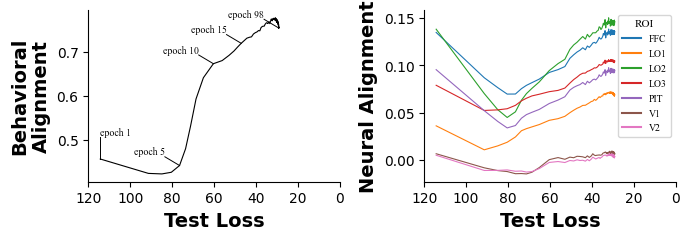

In [27]:
# Side-by-side behavioral vs neural alignment
fig, axes = plt.subplots(1, 2, figsize=(7, 2.5), sharey=False)

# Left: behavioral alignment vs loss
plot_behavior_vs_loss(
    baseline_seed1_ba_results,  # or whichever df you want
    ax=axes[0],
)

# Right: neural alignment vs loss
# Remove rois rLOC and lLOC, and rename va-7 to LO1 and va-8 to LO2 before plotting
plot_df = baseline_seed1_nod_df
plot_neural_alignment_vs_loss(
    plot_df,
    plot_rois=['V1', 'V2', 'LO1', 'LO2', 'LO3', 'PIT', 'FFC'],
    ax=axes[1]
)

plt.tight_layout()
plt.show()

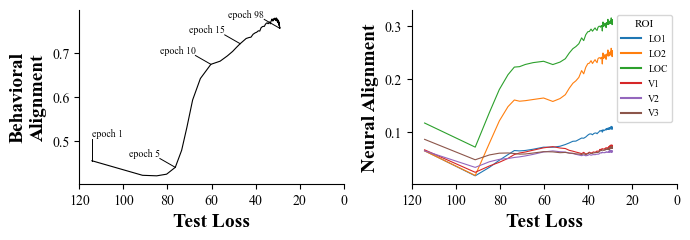

In [28]:
# Side-by-side behavioral vs neural alignment
fig, axes = plt.subplots(1, 2, figsize=(7, 2.5), sharey=False)

# Left: behavioral alignment vs loss
plot_behavior_vs_loss(
    baseline_seed1_ba_results,  # or whichever df you want
    ax=axes[0],
)

# Right: neural alignment vs loss
# Remove rois rLOC and lLOC, and rename va-7 to LO1 and va-8 to LO2 before plotting
plot_df = baseline_seed1_things_df[~baseline_seed1_things_df['roi'].isin(['rLOC', 'lLOC'])].copy()
plot_df['roi'] = plot_df['roi'].replace({'va-1': 'V1', 'va-2': 'V2', 'va-3': 'V3', 'va-7': 'LO1', 'va-8': 'LO2'})
plot_neural_alignment_vs_loss(
    plot_df,
    ax=axes[1]
)

plt.tight_layout()
plt.show()

# Figure 4(A)

### Change in behavioral alignment at single-epoch perturbations

<Axes: xlabel='Perturbation Epoch', ylabel='$\\Delta$ Behavioral Alignment'>

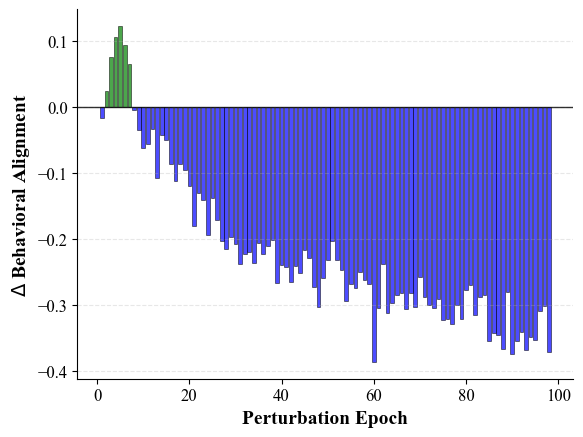

In [29]:
plot_single_epoch_delta_behavioral_alignment(baseline_seed1_ba_results, sweep_seed1_ba_results)

# Figure 4(B)

### Change in test loss at single epoch perturbations

<Axes: xlabel='Perturbation Epoch', ylabel='$\\Delta$ Test Loss'>

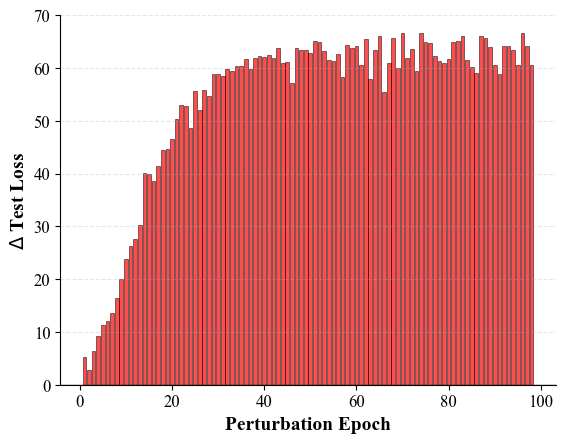

In [30]:
plot_single_epoch_delta_test_loss(baseline_seed1_ba_results, sweep_seed1_ba_results)

# Figure 4(C)

### Change in neural alignment at single epoch perturbations

(<Figure size 1600x600 with 8 Axes>,
 {'FFC':           run_name  perturbation_epoch  delta_neural_alignment  \
  0    training_run1                   1                0.009477   
  1    training_run2                   2                0.027089   
  2    training_run3                   3                0.044562   
  3    training_run4                   4                0.062549   
  4    training_run5                   5                0.065233   
  ..             ...                 ...                     ...   
  92  training_run94                  94               -0.055395   
  93  training_run95                  95               -0.055126   
  94  training_run96                  96               -0.042650   
  95  training_run97                  97               -0.052014   
  96  training_run98                  98               -0.051874   
  
      perturbed_neural_alignment  baseline_neural_alignment  
  0                     0.144219                   0.134742  
  1          

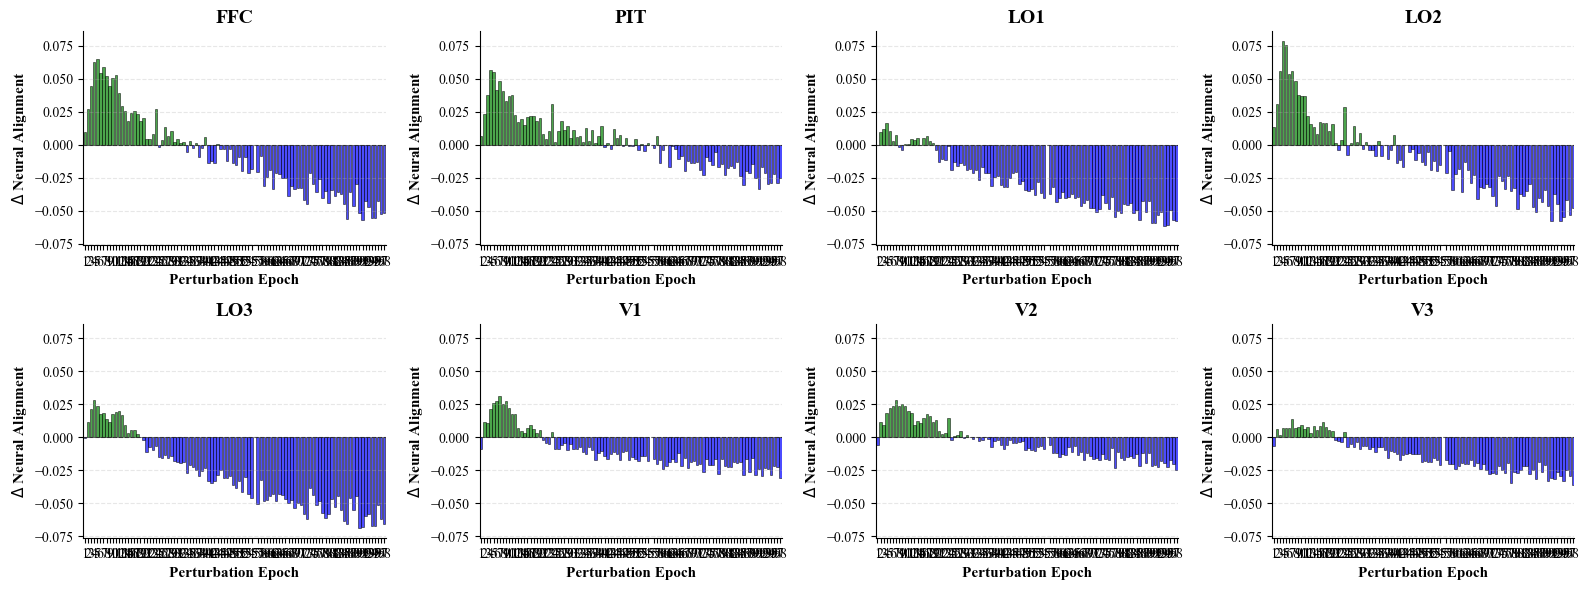

In [31]:
plot_single_epoch_delta_neural_alignment(
    baseline_seed1_nod_df,
    sweep_seed1_nod_neural_results,
    perturbed_runs_is_mapping=False,
    plot_rois=['FFC', 'PIT', 'LO1', 'LO2', 'LO3', 'V1', 'V2', 'V3']
)

# Figure 5

### Maximum behavioral alignment achieved compared to baseline

In [32]:
# Get all of the training run results from the perturbation length experiments.

# path to base directory of the perturbation length experiments
perturb_length_base_dir = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/length_experiments/perturb_length_experiments_baselineseed1_perturbseed0')

# list all training run directories in the results_dir
run_dirs = sorted([d for d in perturb_length_base_dir.iterdir() 
                  if d.is_dir()
                  and d.name.startswith('random_target')])

for run_dir in run_dirs:
    print(run_dir.name)

random_target_e10_l10
random_target_e10_l2
random_target_e10_l20
random_target_e10_l30
random_target_e10_l40
random_target_e10_l5
random_target_e10_l50
random_target_e13_l10
random_target_e13_l20
random_target_e13_l30
random_target_e13_l40
random_target_e13_l5
random_target_e13_l50
random_target_e16_l10
random_target_e16_l20
random_target_e16_l30
random_target_e16_l40
random_target_e16_l5
random_target_e16_l50
random_target_e19_l10
random_target_e19_l20
random_target_e19_l30
random_target_e19_l40
random_target_e19_l5
random_target_e19_l50
random_target_e1_l10
random_target_e1_l2
random_target_e1_l20
random_target_e1_l30
random_target_e1_l40
random_target_e1_l5
random_target_e1_l50
random_target_e20_l10
random_target_e20_l2
random_target_e20_l20
random_target_e20_l30
random_target_e20_l40
random_target_e20_l5
random_target_e20_l50
random_target_e22_l5
random_target_e2_l10
random_target_e2_l2
random_target_e2_l20
random_target_e2_l30
random_target_e2_l40
random_target_e2_l5
random_target

In [33]:
# in every run_dir, find the folder called either metrics.csv or training_res.csv
# and read it in as a pandas dataframe

#all_perturb_length_dfs should be a dict mapping run names (strings) to DataFrames, or a list of DataFrames, where each DataFrame has a 'test_loss' column and its indices represent epochs. 

all_perturb_length_dfs = {}

for run_dir in run_dirs:
    if 'metrics.csv' in os.listdir(run_dir):
        print(f'Found results csv in {run_dir.name}')
        df = pd.read_csv(run_dir / 'metrics.csv')
        all_perturb_length_dfs[run_dir.name] = df
    elif 'training_res.csv' in os.listdir(run_dir):
        print(f'Found results csv in {run_dir.name}')
        df = pd.read_csv(run_dir / 'training_res.csv')
        all_perturb_length_dfs[run_dir.name] = df

Found results csv in random_target_e10_l10
Found results csv in random_target_e10_l2
Found results csv in random_target_e10_l20
Found results csv in random_target_e10_l30
Found results csv in random_target_e10_l40
Found results csv in random_target_e10_l5
Found results csv in random_target_e10_l50
Found results csv in random_target_e13_l10
Found results csv in random_target_e13_l20
Found results csv in random_target_e13_l30
Found results csv in random_target_e13_l40
Found results csv in random_target_e13_l5
Found results csv in random_target_e13_l50
Found results csv in random_target_e16_l10
Found results csv in random_target_e16_l20
Found results csv in random_target_e16_l30
Found results csv in random_target_e16_l40
Found results csv in random_target_e16_l5
Found results csv in random_target_e16_l50
Found results csv in random_target_e19_l10
Found results csv in random_target_e19_l20
Found results csv in random_target_e19_l30
Found results csv in random_target_e19_l40
Found results c

In [34]:
# filter out the rows that were from before early stopping kicked in (but after the minimum test loss was achieved)

all_perturb_length_data = {}

for run_name, df in all_perturb_length_dfs.items():
    if len(df) == 0:
        all_perturb_length_data[run_name] = df
        continue

    # Find the epoch with minimum test loss
    min_test_loss_idx = df['test_loss'].idxmin()

    # Keep all rows up to and including the minimum test loss epoch
    filtered_df = df.loc[:min_test_loss_idx].copy()

    all_perturb_length_data[run_name] = filtered_df

    # Print info about the filtering
    original_epochs = len(df)
    filtered_epochs = len(filtered_df)
    removed_epochs = original_epochs - filtered_epochs
    print(f"{run_name}: {original_epochs} -> {filtered_epochs} epochs "
            f"(removed {removed_epochs} epochs after minimum test loss)")

random_target_e10_l10: 109 -> 89 epochs (removed 20 epochs after minimum test loss)
random_target_e10_l2: 95 -> 75 epochs (removed 20 epochs after minimum test loss)
random_target_e10_l20: 109 -> 89 epochs (removed 20 epochs after minimum test loss)
random_target_e10_l30: 119 -> 99 epochs (removed 20 epochs after minimum test loss)
random_target_e10_l40: 127 -> 107 epochs (removed 20 epochs after minimum test loss)
random_target_e10_l5: 97 -> 77 epochs (removed 20 epochs after minimum test loss)
random_target_e10_l50: 136 -> 116 epochs (removed 20 epochs after minimum test loss)
random_target_e13_l10: 106 -> 86 epochs (removed 20 epochs after minimum test loss)
random_target_e13_l20: 106 -> 86 epochs (removed 20 epochs after minimum test loss)
random_target_e13_l30: 124 -> 104 epochs (removed 20 epochs after minimum test loss)
random_target_e13_l40: 124 -> 104 epochs (removed 20 epochs after minimum test loss)
random_target_e13_l5: 106 -> 86 epochs (removed 20 epochs after minimum test

In [35]:
# Extract metadata for each run
run_metadata = []
for run_name, df in all_perturb_length_dfs.items():
    # Parse run name - format appears to be "random_target_e{epoch}_l{length}"
    # Let's handle this more carefully
    if 'random_target_e' in run_name:
        # Extract epoch and length from format like "random_target_e70_l20"
        parts = run_name.split('_')
        start_epoch = None
        length = None
        
        for part in parts:
            if part.startswith('e') and part[1:].isdigit():
                start_epoch = int(part[1:])
            elif part.startswith('l') and part[1:].isdigit():
                length = int(part[1:])
        
        if start_epoch is not None and length is not None:
            run_metadata.append({
                'run_name': run_name,
                'start_epoch': start_epoch,
                'length': length,
                'df': df
            })
            
            print(f"Run: {run_name}")
            print(f"  Start epoch: {start_epoch}")
            print(f"  Length: {length} epochs")
            print(f"  Total epochs: {len(df)}")
            print()
        else:
            print(f"Warning: Could not parse run name: {run_name}")
    else:
        print(f"Warning: Unexpected run name format: {run_name}")

print(f"Total runs parsed: {len(run_metadata)}")

Run: random_target_e10_l10
  Start epoch: 10
  Length: 10 epochs
  Total epochs: 109

Run: random_target_e10_l2
  Start epoch: 10
  Length: 2 epochs
  Total epochs: 95

Run: random_target_e10_l20
  Start epoch: 10
  Length: 20 epochs
  Total epochs: 109

Run: random_target_e10_l30
  Start epoch: 10
  Length: 30 epochs
  Total epochs: 119

Run: random_target_e10_l40
  Start epoch: 10
  Length: 40 epochs
  Total epochs: 127

Run: random_target_e10_l5
  Start epoch: 10
  Length: 5 epochs
  Total epochs: 97

Run: random_target_e10_l50
  Start epoch: 10
  Length: 50 epochs
  Total epochs: 136

Run: random_target_e13_l10
  Start epoch: 13
  Length: 10 epochs
  Total epochs: 106

Run: random_target_e13_l20
  Start epoch: 13
  Length: 20 epochs
  Total epochs: 106

Run: random_target_e13_l30
  Start epoch: 13
  Length: 30 epochs
  Total epochs: 124

Run: random_target_e13_l40
  Start epoch: 13
  Length: 40 epochs
  Total epochs: 124

Run: random_target_e13_l5
  Start epoch: 13
  Length: 5 epoc

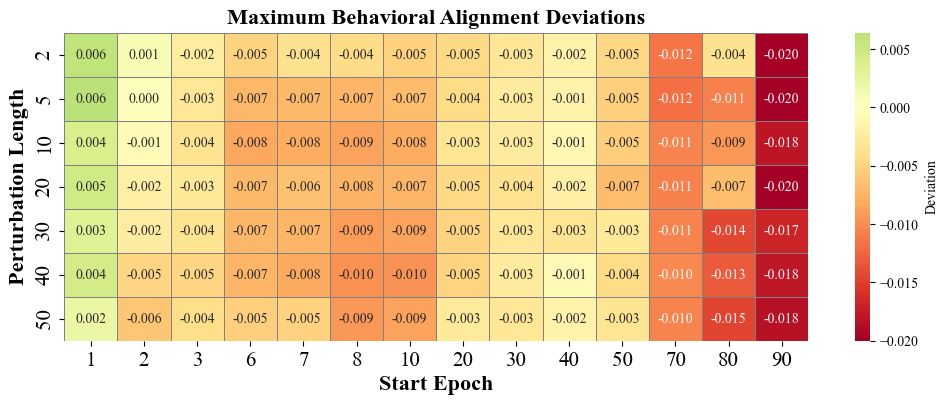

In [36]:
# Get maximum behavioral alignment from baseline run
baseline_max_ba = baseline_seed1_ba_results['behavioral_rsa_rho'].max()
baseline_max_epoch = baseline_seed1_ba_results.loc[baseline_seed1_ba_results['behavioral_rsa_rho'].idxmax(), 'epoch']

# Collect maximum behavioral alignment deviations
deviation_data = []

for run_info in run_metadata:
    run_name = run_info['run_name']
    df = run_info['df']
    start_epoch = run_info['start_epoch']
    length = run_info['length']
    
    # Sort by epoch
    df_sorted = df.sort_values('epoch')
    
    if len(df_sorted) == 0:
        continue
    
    # Get maximum behavioral alignment value reached in this run
    max_ba = df_sorted['behavioral_rsa_rho'].max()
    max_ba_epoch = df_sorted.loc[df_sorted['behavioral_rsa_rho'].idxmax(), 'epoch']
    
    # Calculate deviation from baseline maximum
    # (positive = better than baseline, negative = worse)
    deviation = max_ba - baseline_max_ba

    deviation_data.append({
        'start_epoch': start_epoch,
        'length': length,
        'deviation': deviation,
        'max_ba': max_ba,
        'max_ba_epoch': max_ba_epoch,
        'baseline_max_ba': baseline_max_ba
    })

# Convert to DataFrame
deviation_df = pd.DataFrame(deviation_data)

# Exclude any rows you want to exclude
deviation_df = deviation_df[deviation_df['start_epoch'] != 13]
deviation_df = deviation_df[deviation_df['start_epoch'] != 16]
deviation_df = deviation_df[deviation_df['start_epoch'] != 19]
deviation_df = deviation_df[deviation_df['start_epoch'] != 22]
deviation_df = deviation_df[deviation_df['start_epoch'] != 60]
deviation_df = deviation_df[deviation_df['start_epoch'] != 58]
deviation_df = deviation_df[deviation_df['start_epoch'] != 94]



# Create pivot table for heatmap: rows (y-axis) = length, columns (x-axis) = start_epoch
heatmap_data = deviation_df.pivot_table(
    values='deviation',
    index='length',
    columns='start_epoch',
    aggfunc='first'  # Should only be one value per combination, but use first to be safe
)

# Sort by start_epoch (columns) and length (rows)
heatmap_data = heatmap_data.sort_index(axis=0)  # Sort rows (length)
heatmap_data = heatmap_data.sort_index(axis=1)  # Sort columns (start_epoch)

# Establish shared color scale based on this first heatmap
heatmap_vmin = heatmap_data.min().min()
heatmap_vmax = heatmap_data.max().max()
heatmap_scale = (heatmap_vmin, heatmap_vmax)

# Create the heatmap with smaller figure size
plt.figure(figsize=(12, 4))
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',  # Red-Yellow-Green colormap (red=worse, green=better)
    center=0,  # Center colormap at 0 (no deviation)
    vmin=heatmap_vmin,
    vmax=heatmap_vmax,
    cbar_kws={'label': 'Deviation'},
    linewidths=0.5,
    linecolor='gray'
)
ax.set_xlabel('Start Epoch', fontsize=16, fontweight='bold')
ax.set_ylabel('Perturbation Length', fontsize=16, fontweight='bold')
ax.set_title('Maximum Behavioral Alignment Deviations', fontsize=16, fontweight='bold')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

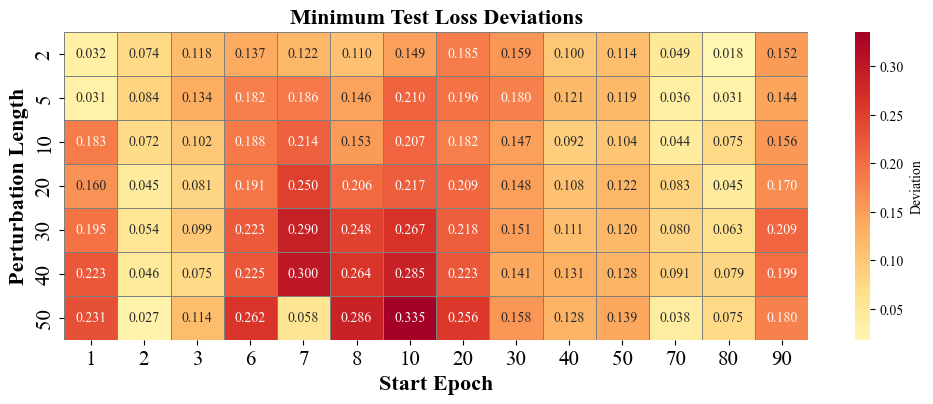

In [37]:
fig, ax1, dev1, hm1, dmin, dmax = plot_min_test_loss_heatmap(
    baseline_seed1_ba_results, seed1_run_metadata, exclude_start_epochs=[13, 16, 19, 22, 60, 58, 94]
)

# Supplementary Figures

### Baseline Behavioral Alignment - Seed 2

<Axes: xlabel='Test Loss', ylabel='Behavioral\nAlignment'>

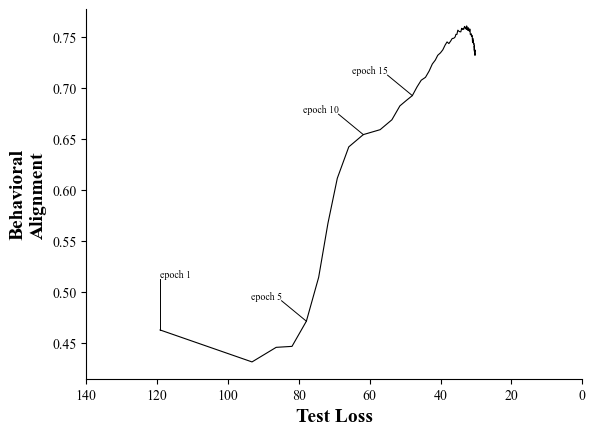

In [38]:
plot_behavior_vs_loss(baseline_seed2_ba_results)

### Baseline Behavioral Alignment - Seed 2

<Axes: xlabel='Test Loss', ylabel='Behavioral\nAlignment'>

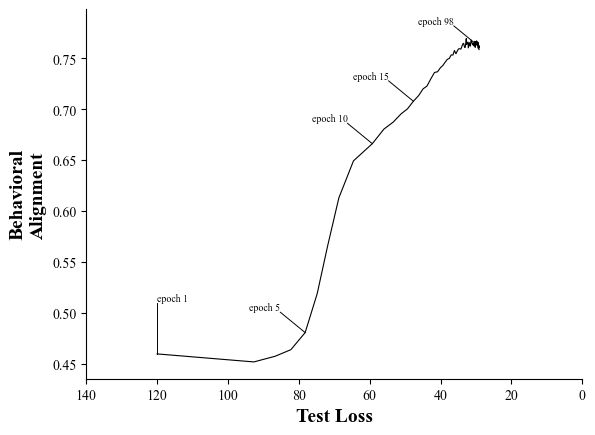

In [39]:
plot_behavior_vs_loss(baseline_seed3_ba_results)

### Change in behavioral alignment at single-epoch perturbations - Seed 2

<Axes: xlabel='Perturbation Epoch', ylabel='$\\Delta$ Behavioral Alignment'>

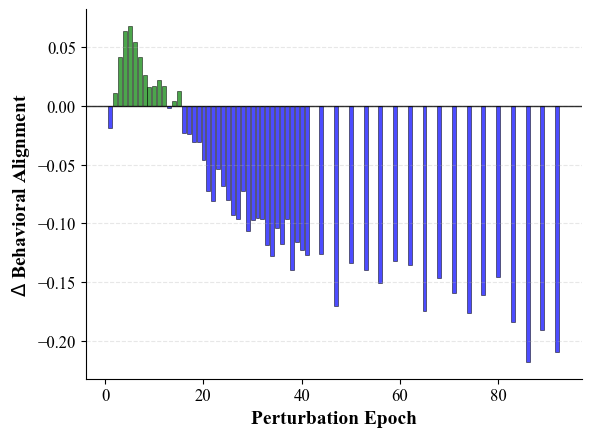

In [40]:
plot_single_epoch_delta_behavioral_alignment(baseline_seed2_ba_results, sweep_seed2_ba_results)

### Change in behavioral alignment at single-epoch perturbations - Seed 3

<Axes: xlabel='Perturbation Epoch', ylabel='$\\Delta$ Behavioral Alignment'>

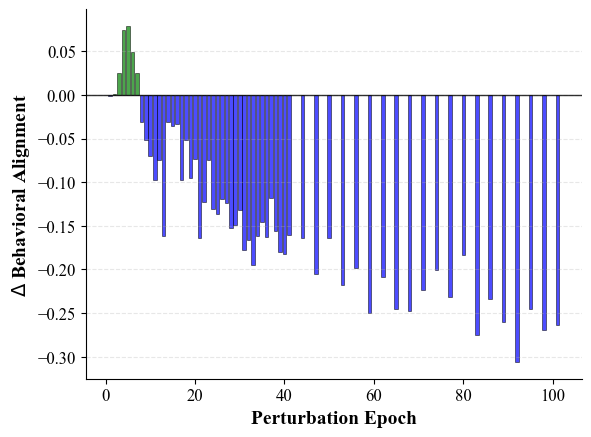

In [41]:
plot_single_epoch_delta_behavioral_alignment(baseline_seed3_ba_results, sweep_seed3_ba_results)

### Change in THINGS neural alignment at single epoch perturbations Seed 1

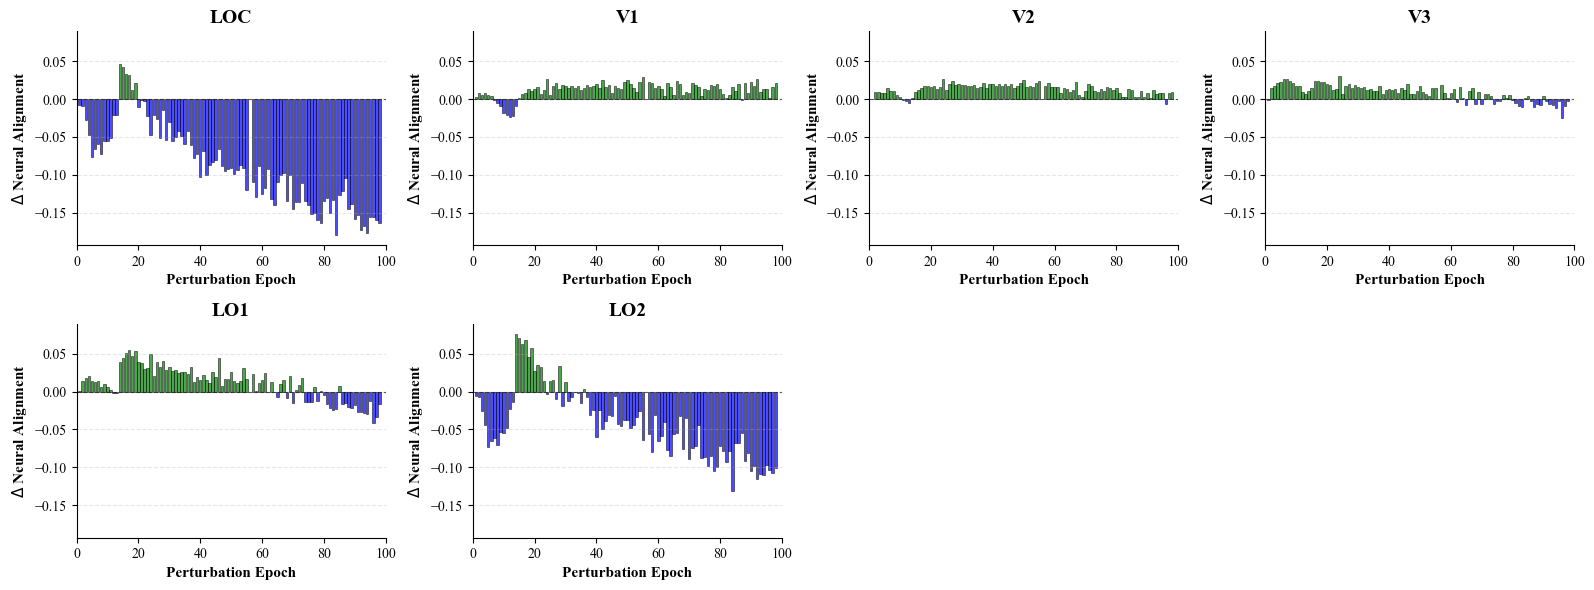

In [42]:
roi_display = {
    "va-1": "V1",
    "va-2": "V2",
    "va-3": "V3",
    "va-7": "LO1",
    "va-8": "LO2",
}

baseline_plot = baseline_seed1_things_df.copy()
baseline_plot["roi"] = baseline_plot["roi"].replace(roi_display)

plot_df = sweep_seed1_things_neural_results.rename(columns={"score": "rho", "region_key": "roi"}).copy()
plot_df["roi"] = plot_df["roi"].replace(roi_display)

# Plot and scale x-axis from 0 to 100 by increments of 20
ax_or_fig, _ = plot_single_epoch_delta_neural_alignment(
    baseline_plot,
    plot_df,
    perturbed_runs_is_mapping=False,
    plot_rois=["LOC", "V1", "V2", "V3", "LO1", "LO2"],
)

# If return is figure, get the axes; if axes, use directly
import matplotlib.pyplot as plt

if isinstance(ax_or_fig, plt.Figure):
    axes = ax_or_fig.axes
    for ax in axes:
        ax.set_xlim([0, 100])
        ax.set_xticks(range(0, 101, 20))
else:
    ax = ax_or_fig
    ax.set_xlim([0, 100])
    ax.set_xticks(range(0, 101, 20))

### Change in THINGS neural alignment at single epoch perturbations Seed 2

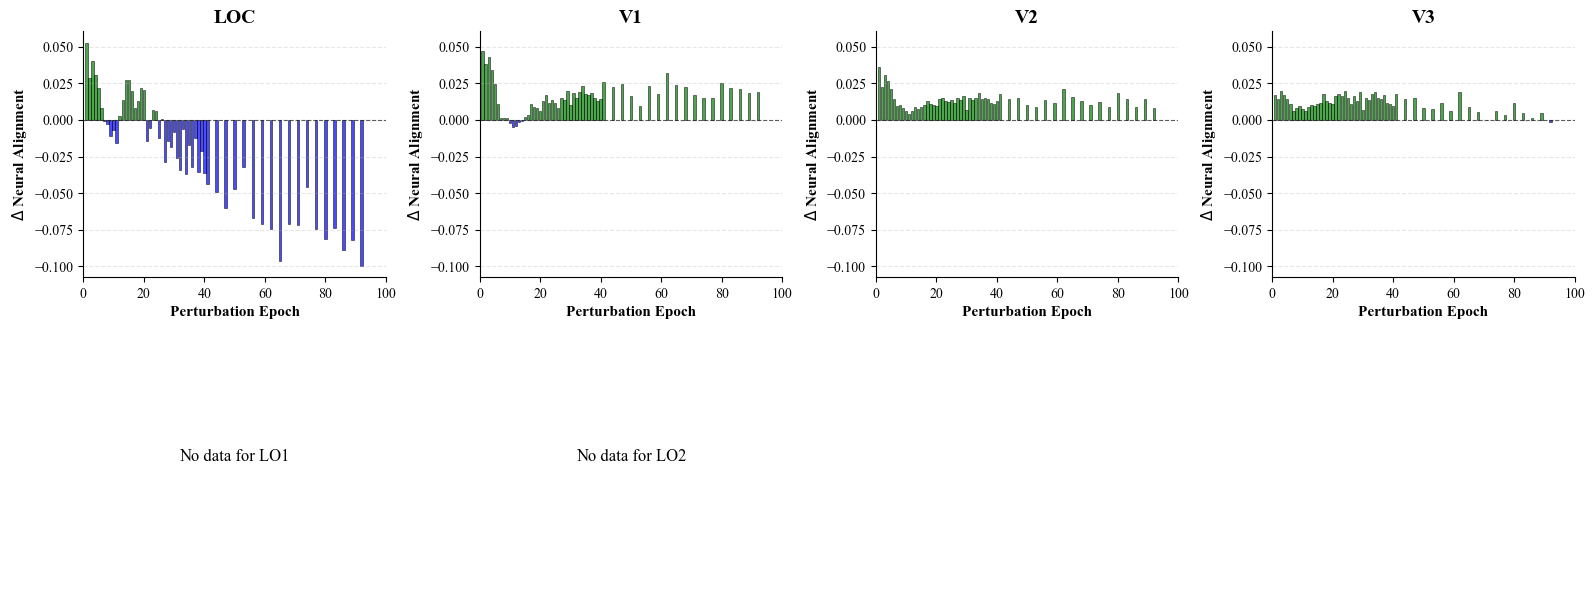

In [43]:
roi_display = {
    "va-1": "V1",
    "va-2": "V2",
    "va-3": "V3",
    "va-7": "LO1",
    "va-8": "LO2",
}

baseline_plot = baseline_seed2_things_df.copy()
baseline_plot["roi"] = baseline_plot["roi"].replace(roi_display)

plot_df = sweep_seed2_things_neural_results.rename(columns={"score": "rho", "region_key": "roi"}).copy()
plot_df["roi"] = plot_df["roi"].replace(roi_display)

# Plot and scale x-axis from 0 to 100 by increments of 20
ax_or_fig, _ = plot_single_epoch_delta_neural_alignment(
    baseline_plot,
    plot_df,
    perturbed_runs_is_mapping=False,
    plot_rois=["LOC", "V1", "V2", "V3", "LO1", "LO2"],
)

# If return is figure, get the axes; if axes, use directly
import matplotlib.pyplot as plt

if isinstance(ax_or_fig, plt.Figure):
    axes = ax_or_fig.axes
    for ax in axes:
        ax.set_xlim([0, 100])
        ax.set_xticks(range(0, 101, 20))
else:
    ax = ax_or_fig
    ax.set_xlim([0, 100])
    ax.set_xticks(range(0, 101, 20))

### Change in THINGS neural alignment at single epoch perturbations Seed 3

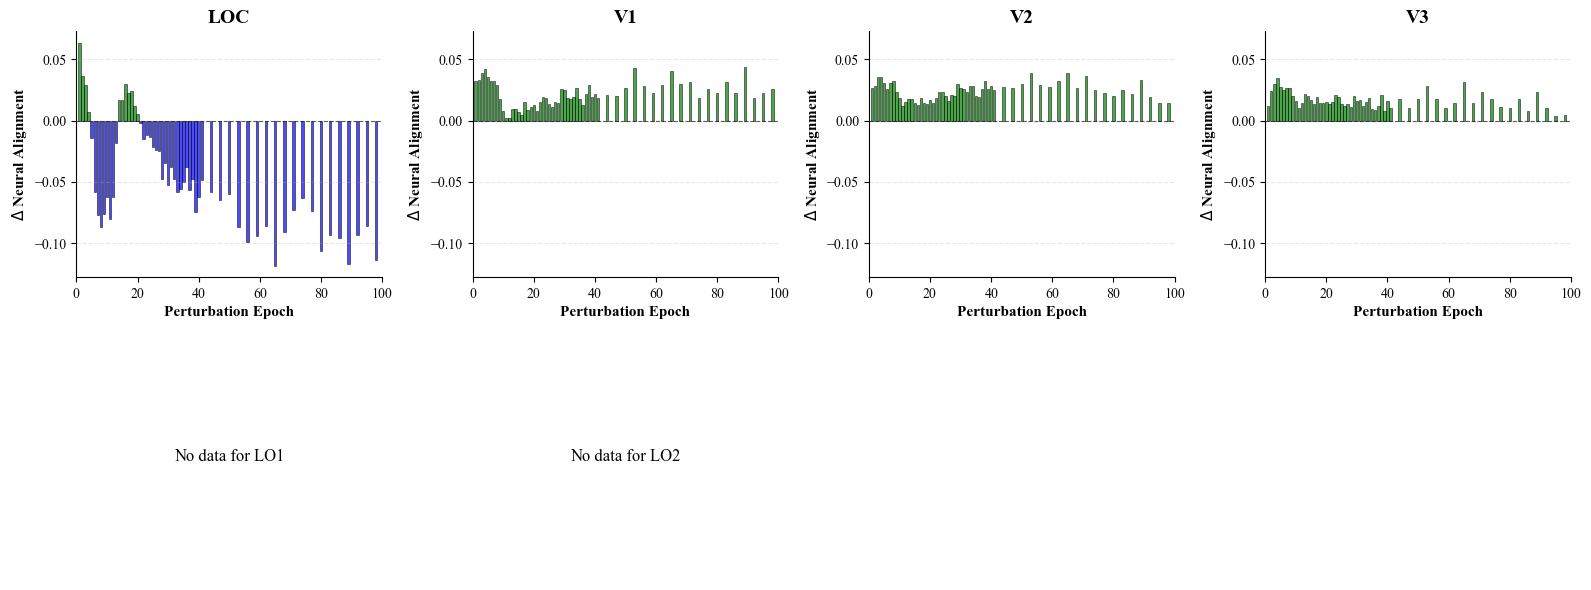

In [44]:
roi_display = {
    "va-1": "V1",
    "va-2": "V2",
    "va-3": "V3",
    "va-7": "LO1",
    "va-8": "LO2",
}

baseline_plot = baseline_seed3_things_df.copy()
baseline_plot["roi"] = baseline_plot["roi"].replace(roi_display)

plot_df = sweep_seed3_things_neural_results.rename(columns={"score": "rho", "region_key": "roi"}).copy()
plot_df["roi"] = plot_df["roi"].replace(roi_display)

# Plot and scale x-axis from 0 to 100 by increments of 20
ax_or_fig, _ = plot_single_epoch_delta_neural_alignment(
    baseline_plot,
    plot_df,
    perturbed_runs_is_mapping=False,
    plot_rois=["LOC", "V1", "V2", "V3", "LO1", "LO2"],
)

# If return is figure, get the axes; if axes, use directly
import matplotlib.pyplot as plt

if isinstance(ax_or_fig, plt.Figure):
    axes = ax_or_fig.axes
    for ax in axes:
        ax.set_xlim([0, 100])
        ax.set_xticks(range(0, 101, 20))
else:
    ax = ax_or_fig
    ax.set_xlim([0, 100])
    ax.set_xticks(range(0, 101, 20))

### Maximum behavioral alignment achieved - Seed 2

### Maximum behavioral alignment achieved - Seed 3

### Minimum test loss achieved - Seed 2

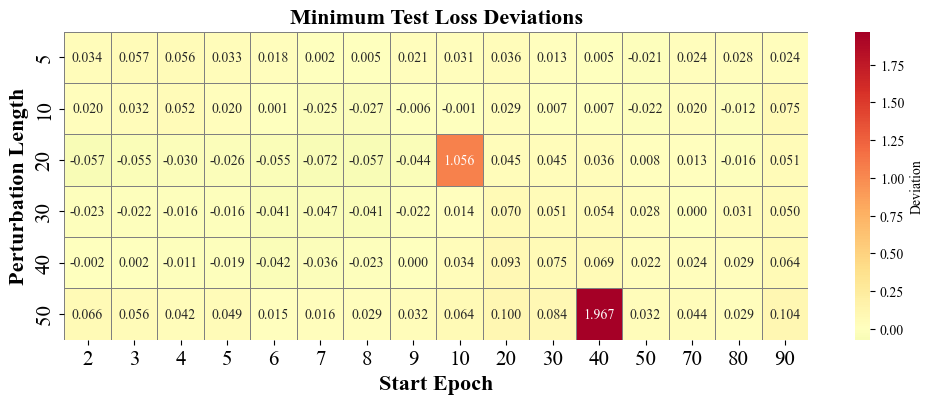

In [45]:
fig, ax1, dev1, hm1, dmin, dmax = plot_min_test_loss_heatmap(
    baseline_seed2_ba_results, seed2_run_metadata, exclude_start_epochs=[13, 16, 19, 22, 60, 58, 94]
)

### Minimum test loss achieved - Seed 3

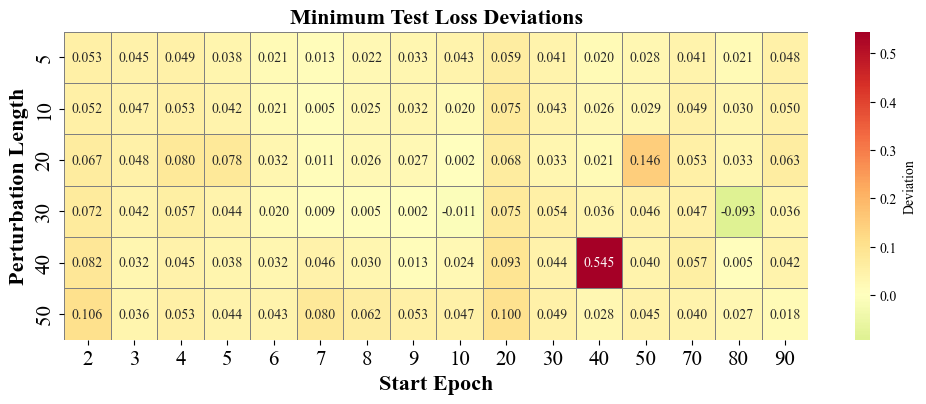

In [46]:
fig, ax1, dev1, hm1, dmin, dmax = plot_min_test_loss_heatmap(
    baseline_seed3_ba_results, seed3_run_metadata, exclude_start_epochs=[13, 16, 19, 22, 60, 58, 94]
)

In [54]:
# Read in the behavioral alignment results from the seed 42 run
# Single-epoch perturbation seed 1
seed42_ba_results = pd.read_csv("/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/test/perturb_sweep_replication/random_target_perturb_seed42/compiled_inference_results_things_behavioral.csv")
seed42_ba_results = seed42_ba_results.rename(columns={'score': 'behavioral_rsa_rho'})
if 'epoch' in seed42_ba_results.columns:
    seed42_ba_results['epoch'] = seed42_ba_results['epoch'] + 1

In [55]:
seed42_ba_results

,epoch_dir,epoch,reference_rdm_name,ref_key,behavioral_rsa_rho,p_value,dataset,evaluation_type,rsa_similarity_metric,model_rdm_distance_metric,reference_rdm_distance_metric,source_file
0,0,1,behavioral_rdm,behavioral_rdm,0.437878,4.843698e-54,things,behavioral,spearman,pearson,pearson,epoch0_length1/test_things_behavioral_inferenc...
1,1,2,behavioral_rdm,behavioral_rdm,0.441905,4.048369e-55,things,behavioral,spearman,pearson,pearson,epoch1_length1/test_things_behavioral_inferenc...
2,2,3,behavioral_rdm,behavioral_rdm,0.485317,1.047137e-67,things,behavioral,spearman,pearson,pearson,epoch2_length1/test_things_behavioral_inferenc...
3,3,4,behavioral_rdm,behavioral_rdm,0.503284,1.803555e-73,things,behavioral,spearman,pearson,pearson,epoch3_length1/test_things_behavioral_inferenc...
4,4,5,behavioral_rdm,behavioral_rdm,0.526771,1.525497e-81,things,behavioral,spearman,pearson,pearson,epoch4_length1/test_things_behavioral_inferenc...
5,5,6,behavioral_rdm,behavioral_rdm,0.551048,1.394682e-90,things,behavioral,spearman,pearson,pearson,epoch5_length1/test_things_behavioral_inferenc...
6,6,7,behavioral_rdm,behavioral_rdm,0.598249,1.897472e-110,things,behavioral,spearman,pearson,pearson,epoch6_length1/test_things_behavioral_inferenc...
7,7,8,behavioral_rdm,behavioral_rdm,0.627240,2.187842e-124,things,behavioral,spearman,pearson,pearson,epoch7_length1/test_things_behavioral_inferenc...
8,8,9,behavioral_rdm,behavioral_rdm,0.661080,1.201430e-142,things,behavioral,spearman,pearson,pearson,epoch8_length1/test_things_behavioral_inferenc...
9,9,10,behavioral_rdm,behavioral_rdm,0.675730,2.587893e-151,things,behavioral,spearman,pearson,pearson,epoch9_length1/test_things_behavioral_inferenc...


In [76]:
compiled = pd.read_csv("/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/test/perturb_sweep_replication/random_target_perturb_seed42/compiled_inference_results_things_behavioral.csv")

# pick the metric to treat as behavioral alignment
compiled = compiled.rename(columns={"score": "behavioral_rsa_rho"})

# shift epoch numbers to be 1-98 instead of 0-97
compiled["epoch"] = compiled["epoch"].astype(int) + 1

# build a mapping: run_name -> DataFrame with epoch + behavioral_rsa_rho
perturbed_runs = {}
for epoch_dir, g in compiled.groupby("epoch_dir"):
    df_run = g[["epoch", "behavioral_rsa_rho"]].copy()
    df_run["epoch"] = df_run["epoch"].astype(int)
    perturbed_runs[f"epoch{epoch_dir}"] = df_run

# baseline_df must have columns ['epoch', 'behavioral_rsa_rho']
# and you must tell the function which epoch was perturbed for each run:
perturbation_epochs = {run_name: int(run_name.replace("epoch", "")) + 1 for run_name in perturbed_runs}


In [77]:
perturbed_runs

{'epoch0':    epoch  behavioral_rsa_rho
 0      1            0.437878,
 'epoch1':    epoch  behavioral_rsa_rho
 1      2            0.441905,
 'epoch2':    epoch  behavioral_rsa_rho
 2      3            0.485317,
 'epoch3':    epoch  behavioral_rsa_rho
 3      4            0.503284,
 'epoch4':    epoch  behavioral_rsa_rho
 4      5            0.526771,
 'epoch5':    epoch  behavioral_rsa_rho
 5      6            0.551048,
 'epoch6':    epoch  behavioral_rsa_rho
 6      7            0.598249,
 'epoch7':    epoch  behavioral_rsa_rho
 7      8             0.62724,
 'epoch8':    epoch  behavioral_rsa_rho
 8      9             0.66108,
 'epoch9':    epoch  behavioral_rsa_rho
 9     10             0.67573,
 'epoch10':     epoch  behavioral_rsa_rho
 10     11            0.679686,
 'epoch11':     epoch  behavioral_rsa_rho
 11     12            0.697284,
 'epoch12':     epoch  behavioral_rsa_rho
 12     13            0.669306,
 'epoch13':     epoch  behavioral_rsa_rho
 13     14            0.70

<Axes: xlabel='Perturbation Epoch', ylabel='$\\Delta$ Behavioral Alignment'>

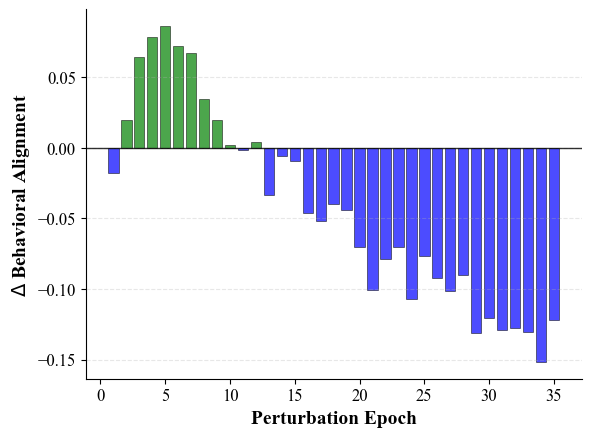

In [79]:
plot_single_epoch_delta_behavioral_alignment(baseline_seed1_ba_results, perturbed_runs,
                                            perturbation_epochs=perturbation_epochs)